# Implementación propia de extracción de features

En esta sección detallaremos el proceso de visualización del dataset y haremos un reporte general de nuestro código de extracción de features y cómo hemos llegado al mismo justificando las decisiones que hemos tomado.


In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'
import sys; print(sys.version)

3.8.2 (default, Mar 26 2020, 15:53:00) 
[GCC 7.3.0]


In [2]:
from import_all import *

In [3]:
""" Load all the train images. """
TRAIN_PATH = './data/sigcomp2009/NISDCC'
PREPROCESSED_PATH='./data/parodi_out/preproc'
FEATURES_PATH = './data/parodi_out/features'
AUGMENTATION_PATH = './data/parodi_out/augmented'
FEATURE_FFT_ON = False

get_fns = ds_sigcomp2009.get_authentic_signatures
get_x = ds_sigcomp2009.get_x
get_y = ds_sigcomp2009.get_y

In [4]:
raw_dataset = L(get_fns(TRAIN_PATH))
print("Lodaded {} files.".format(len(raw_dataset)))
raw_dataset

Lodaded 60 files.


(#60) [Path('data/sigcomp2009/NISDCC/NISDCC-005_005_004_6g.PNG'),Path('data/sigcomp2009/NISDCC/NISDCC-002_002_003_6g.PNG'),Path('data/sigcomp2009/NISDCC/NISDCC-008_008_004_6g.PNG'),Path('data/sigcomp2009/NISDCC/NISDCC-005_005_005_6g.PNG'),Path('data/sigcomp2009/NISDCC/NISDCC-010_010_002_6g.PNG'),Path('data/sigcomp2009/NISDCC/NISDCC-007_007_003_6g.PNG'),Path('data/sigcomp2009/NISDCC/NISDCC-009_009_003_6g.PNG'),Path('data/sigcomp2009/NISDCC/NISDCC-010_010_003_6g.PNG'),Path('data/sigcomp2009/NISDCC/NISDCC-010_010_001_6g.PNG'),Path('data/sigcomp2009/NISDCC/NISDCC-002_002_001_6g.PNG')...]

## Preprocesamiento

Para el preprocesamiento decidimos binarizar la imagen. Este es un procedimiento clásico en la literatura. Se optó por aplicar un filtro gaussiano y luego binarización Otsu puesto que así se observaron los mejores (más nítidos y representativos) resultados, como se pueden observar en las figuras a continuación. Para ver los métodos de binarización se consultó la documentación de OpenCV(https://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.html).


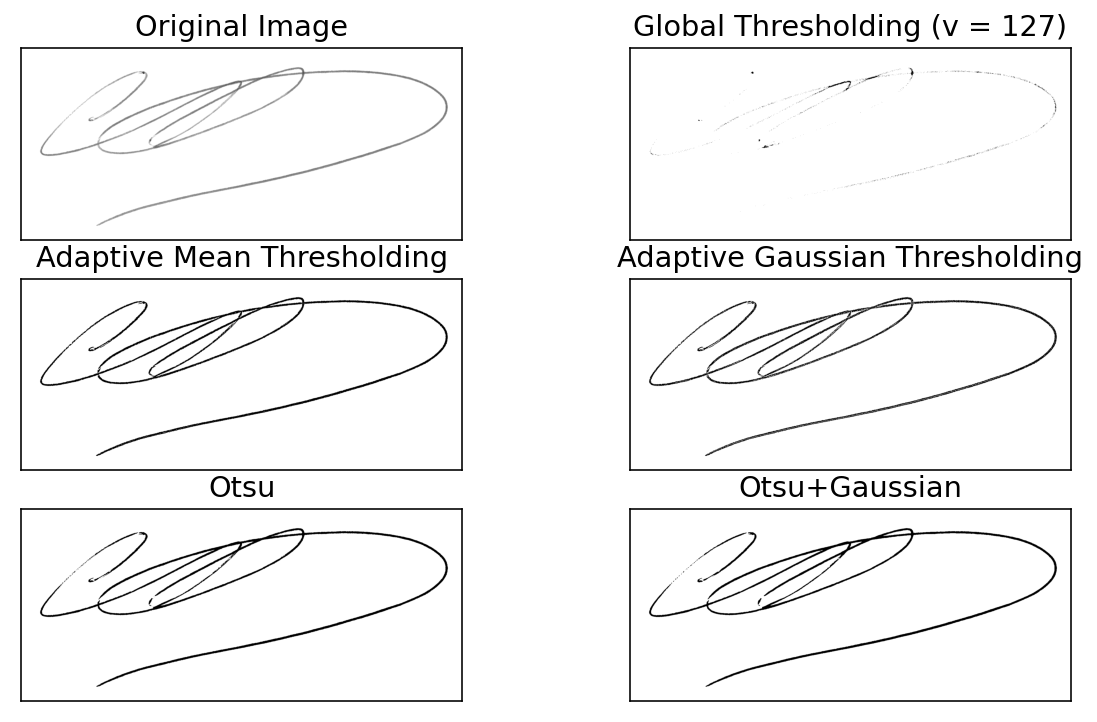

In [5]:
image_fp = random.choice(list(raw_dataset))
img = Image.open(image_fp)
preprocess_choose(img)

## Visualización del dataset

Es importante a la hora de encarar un problema de Machine Learning visualizar los datos para ver que forma tienen. Es un error de principiante aventurarse a implementar sin visualizar que pinta tienen.
La grilla de imágenes abajo impresa muestra firmas originales en la primera fila y firmas de otros autores en las filas subsiguientes (el título es el id del autor de la firma).

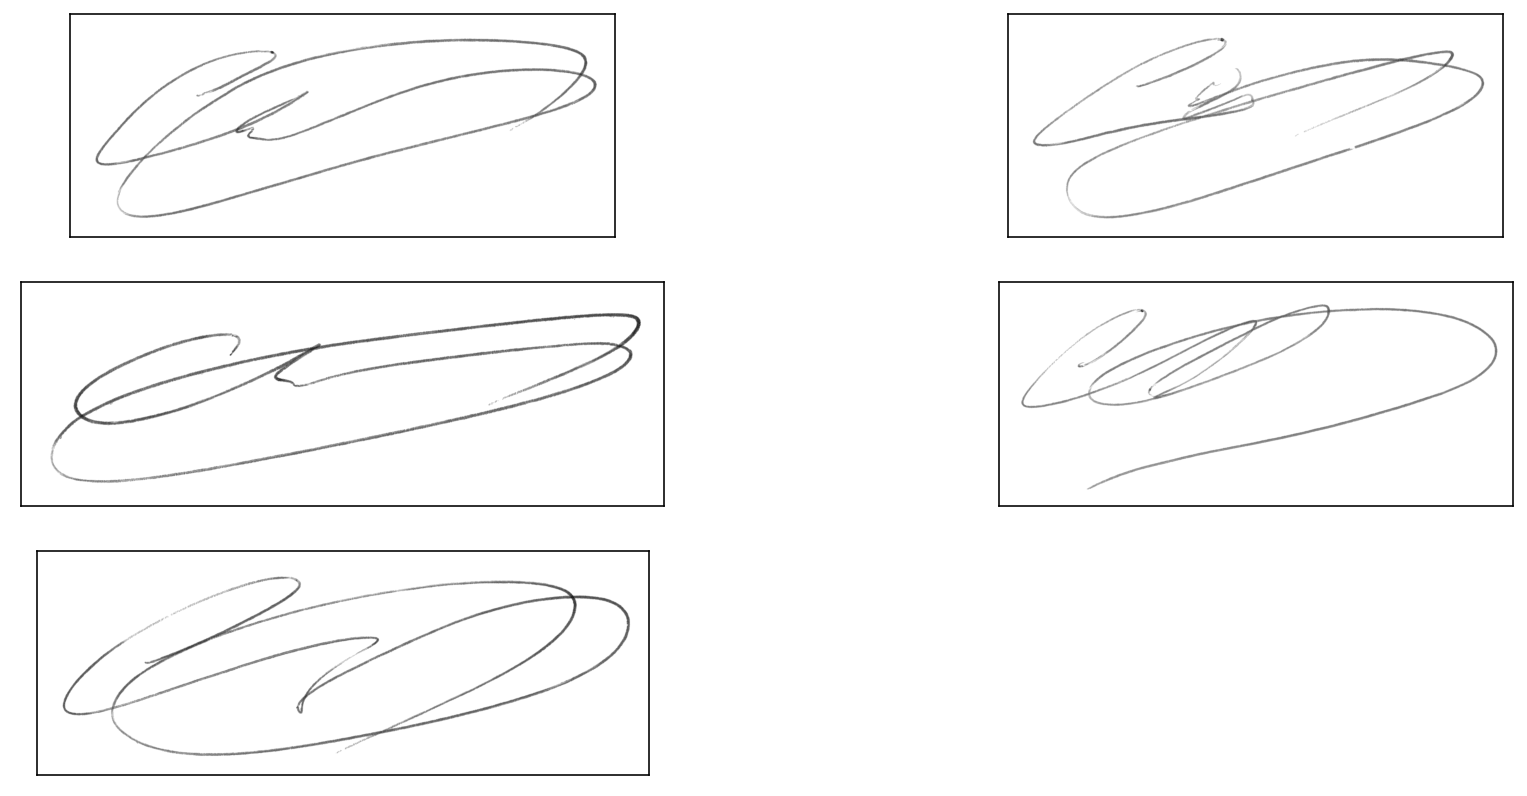

In [6]:
""" Show dataset """
author = ds_sigcomp2009.get_y(image_fp)
images_fp = [f for f in raw_dataset if ds_sigcomp2009.get_y(f)==author ]

imgs = [ds_sigcomp2009.get_x(f) for f in images_fp]
plot_images_grid(imgs,width=2, figsize=(15,7))

In [9]:
""" Preprocess dataset. """
empty_dir(PREPROCESSED_PATH)

Are you sure to delete ./data/parodi_out/preproc? ['yes' for yes]
yes


In [7]:
%%time
def f(x): return preproc_pipeline(PREPROCESSED_PATH, ds_sigcomp2009.get_x, x)
preprocess_dataset = parallel(f,raw_dataset)
len(preprocess_dataset)

CPU times: user 43.6 ms, sys: 51.3 ms, total: 95 ms
Wall time: 754 ms


60

In [5]:
""" Load preprocessed dataset. """
preprocess_dataset = L(get_fns(PREPROCESSED_PATH))
print("Lodaded {} files.".format(len(preprocess_dataset)))

Lodaded 60 files.


## Preprocesamiento (cont.)

Además en el trabajo de procesamiento se decidió negar las imágenes, de modo que los bytes altos (255) correspondan a las firmas (esto lo hacemos porque muchos algoritmos como el de determinar el centro de masa toman al fondo como los bytes en 0).
Finalmente aquí abajo mostramos una imagen que ha pasado por el pipeline de preprocesamiento:

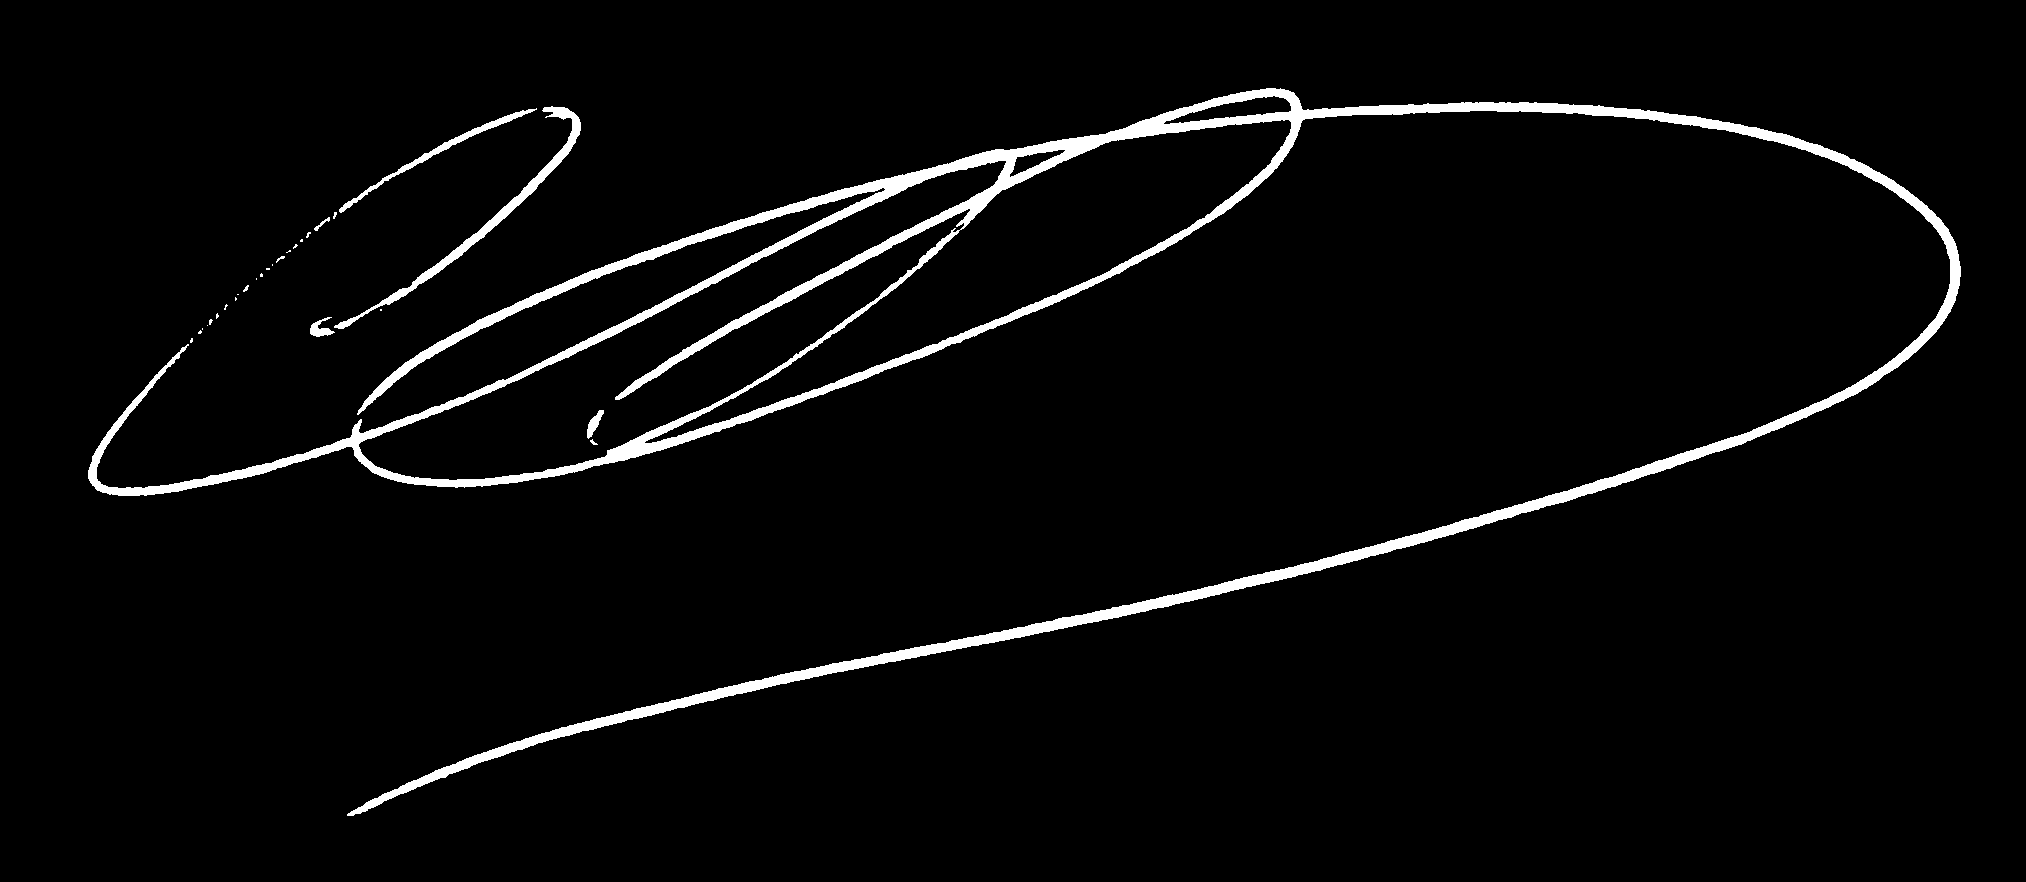

In [6]:
""" Show preprocessed image. """
image_fp = random.choice(preprocess_dataset)
img_preprocessed = Image.open(image_fp)
img_preprocessed

## Data Augmentation

En las secciones en donde entrenamos los clasificadores, podemos ver que el training score es significativamente más alto que el validation score en nuestros clasificadores y eso nos da la pauta de que tenemos problemas de sobreajuste.

Como explicamos en el marco teórico, el data aumentation es un proceso por el cuál obtenemos más datos para entrenar y validar, creando datos sintéticos. Tener más datos nos permite entrenar mejor, y es especialmente útil si tenemos problemas de sobreajuste.

En el caso de las imágenes podemos crear imágenes sintética aplicando transformaciones propias de este tipo de datos como transformaciones afines. En este caso aplicamos rotaciones y escalamiento independiente en los ejes verticales y horizontales.
Es importante aplicar transformaciones que no varíen cualidades semánticas de los datos. Por ejemplo si estuvieramos reconociendo animales tendría sentido espejar las imágenes horizontalmente pero no verticalmente. En este caso, y en el caso general del reconocimiento de texto los espejados le hacen perder sentido a los datos. De este modo también debemos cuidar que las rotaciones no sean significativas para no cambiar demasiado el sentido de los datos. Para ello decidimos rotaciones de entre \[-15, 15\] que juzgamos visualmente que no hacen perder sentido a las firmas. Del mismo modo los parámetros de escalamiento fueron seleccionados con un criterio de prueba/visualización.

Es de suma importancia aclarar que como particionamos por autores en la generación de conjuntos de validación es posible hacer 'data augmentation' antes de la separación en entrenamiento validación. De lo contrario se podrían incurrir en el problema metodológico de 'hermanamiento' del conjunto de datos, incluyendo muestras muy similares en entrenamiento y validación.

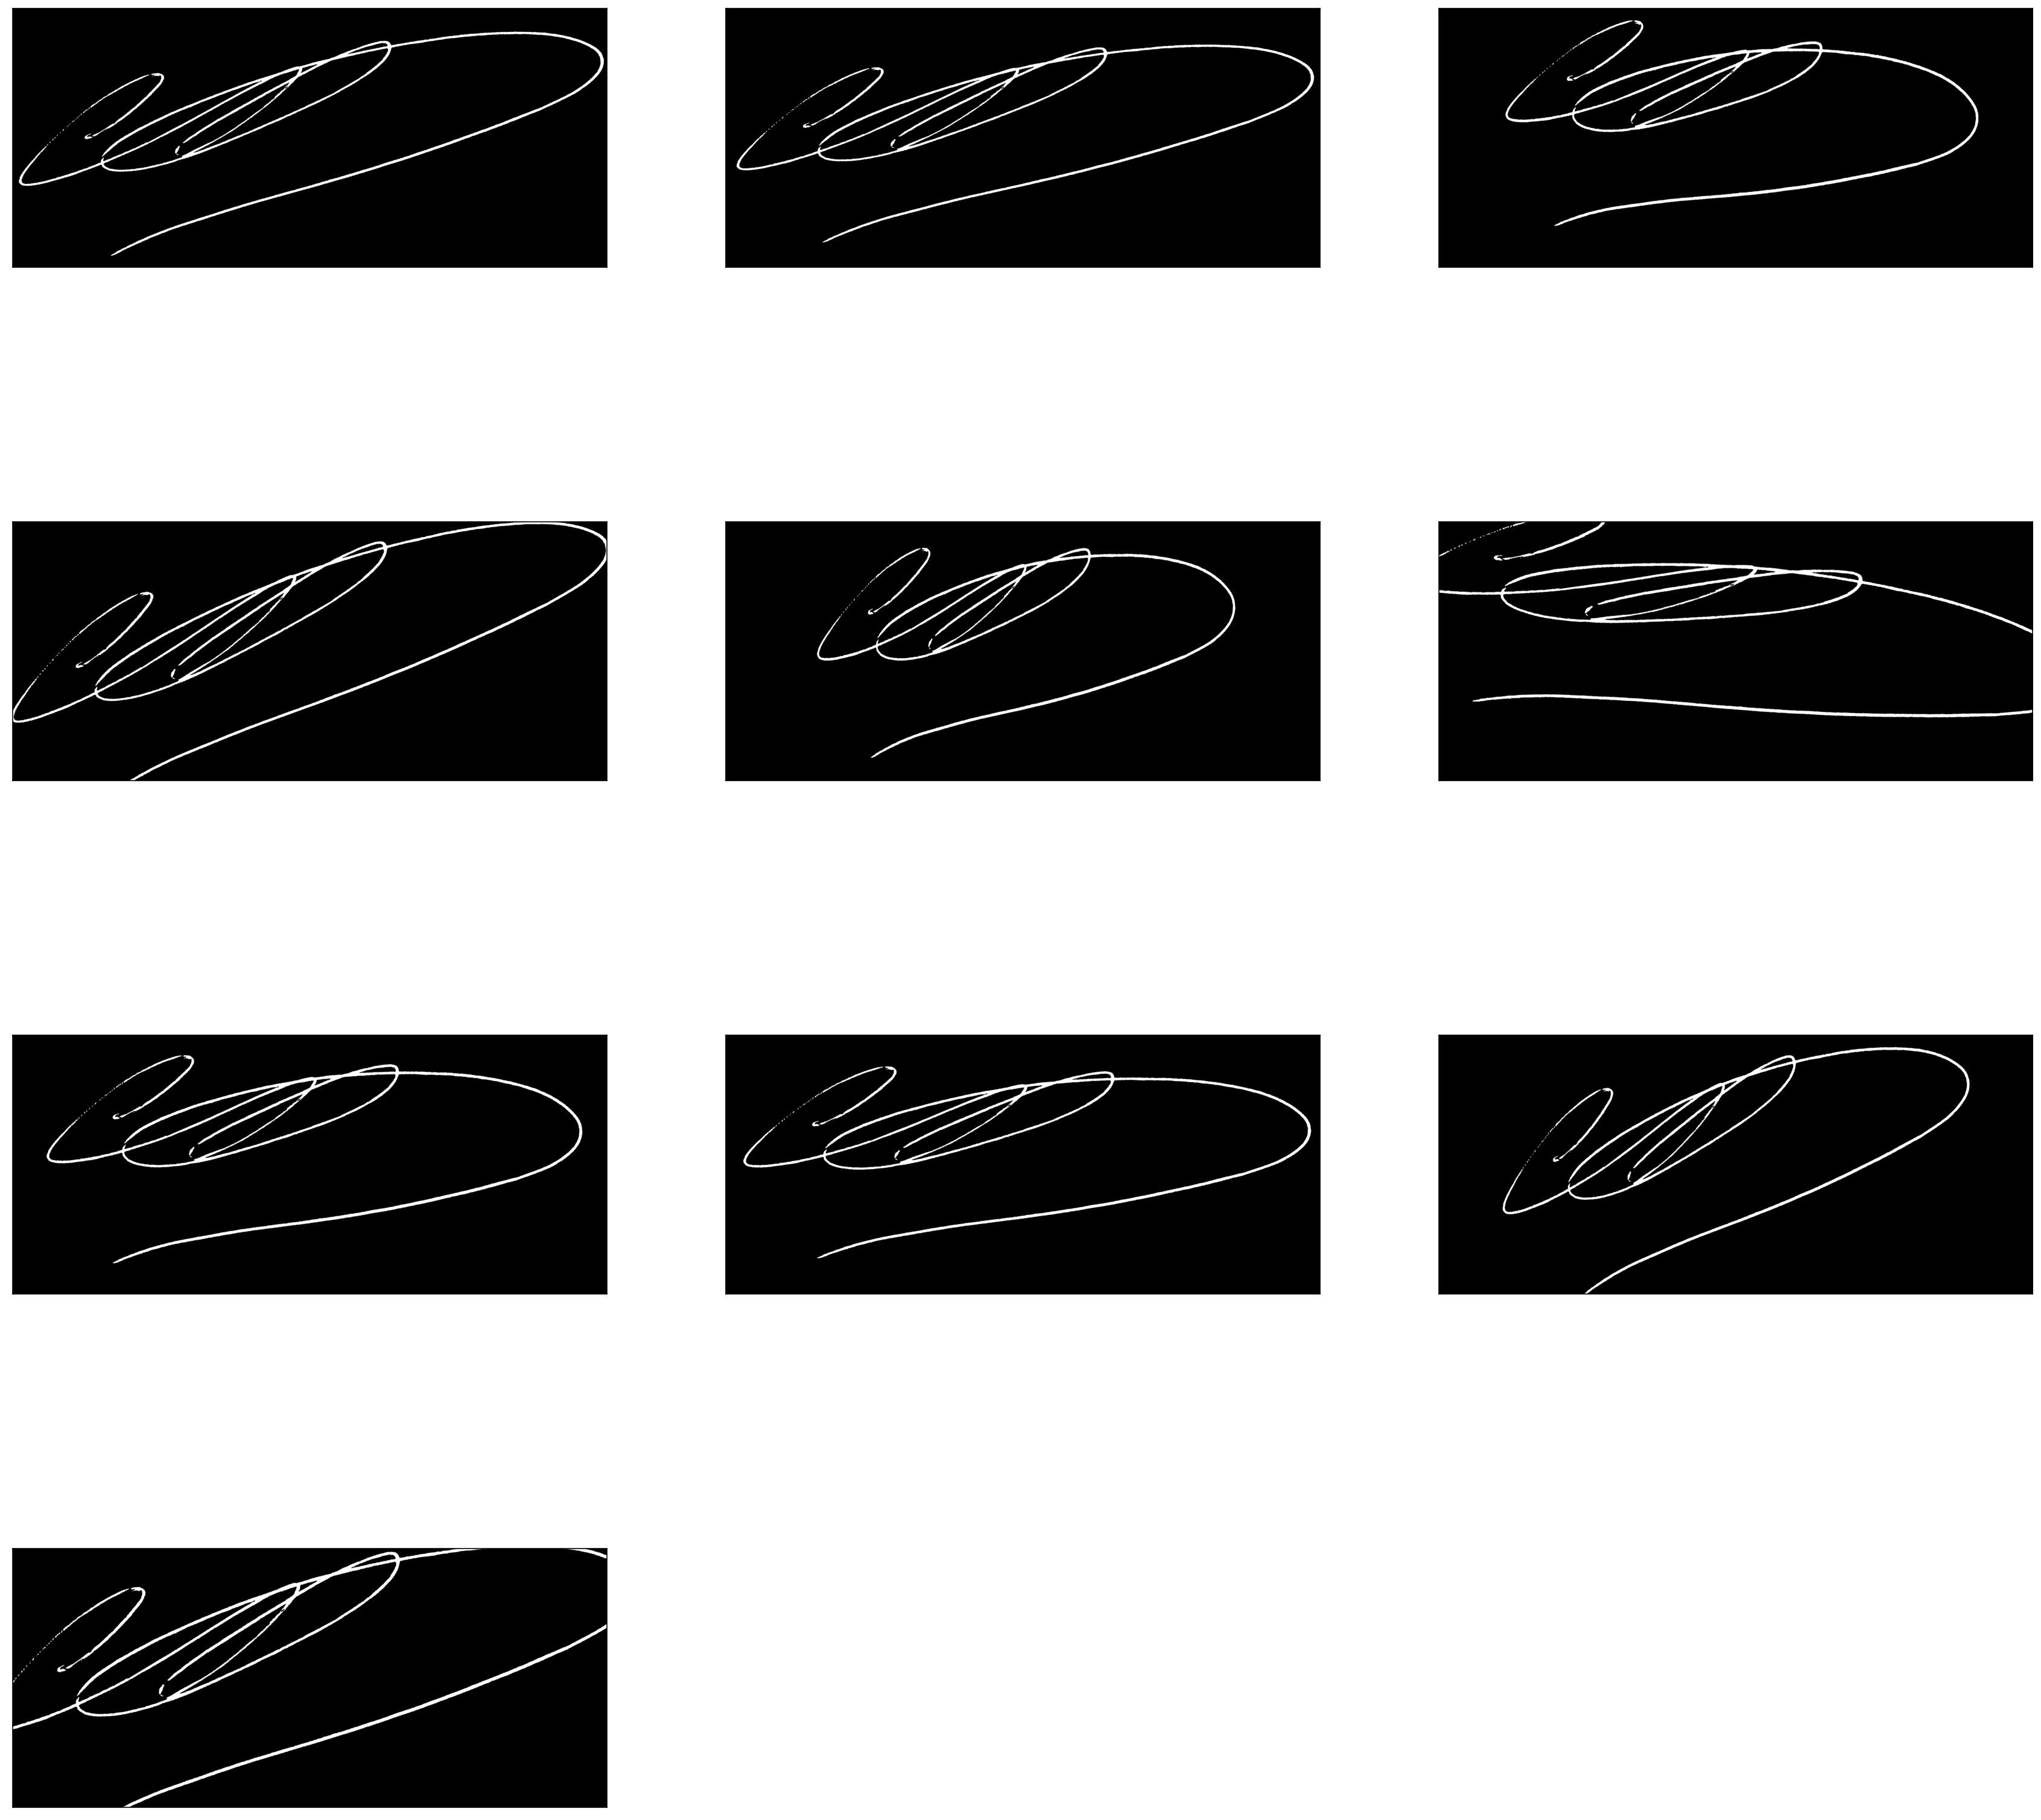

In [37]:
augmented_imgs = data_augmentation(get_x(image_fp), 10)
plot_images_grid(augmented_imgs, width=3, titles=None, figsize=(30,30))

## Extracción de features

Se ha implementado una clase que mantenga información de la grilla circular tal cómo se describi en la tesis de Marianela (cómo el ángulo, las características, un mapeo de cada píxel a la sección correspondiente).

La implementación hace la mayor parte de los loops necesarios gracias a operaciones vectoriales de numpy, valiéndose muchas veces de operaciones de broadcasting. Gracias a ello es posible hacer la extracción de features realmente rápido en "python" (las comillas es porque numpy realiza llamadas a código C/C++ optimizado).

Es importante que en cada paso de implementación se visualice para verificar si lo que se está haciendo es correcto, muchas veces se implementan algoritmos de extracción y clasificación que arrojan resultados finales desalentadores, pero es causa a errores de código en la extracción de características.

In [39]:
%%time
""" Calculate the feature Grid. """
grid = FastGrid(image_fp, ds_sigcomp2009.get_x, N_divisions=16)

CPU times: user 376 ms, sys: 28 ms, total: 404 ms
Wall time: 404 ms


En la siguiente imagen visualizamos las secciones de la grilla: dentro de la clase un miembro almacena las coordenadas de los píxeles de cada sección y hemos coloreado dichos píxeles de blanco, además hemos coloreado de gris el vector inicial de la sección para verificar que lo estamos calculando correctamente.

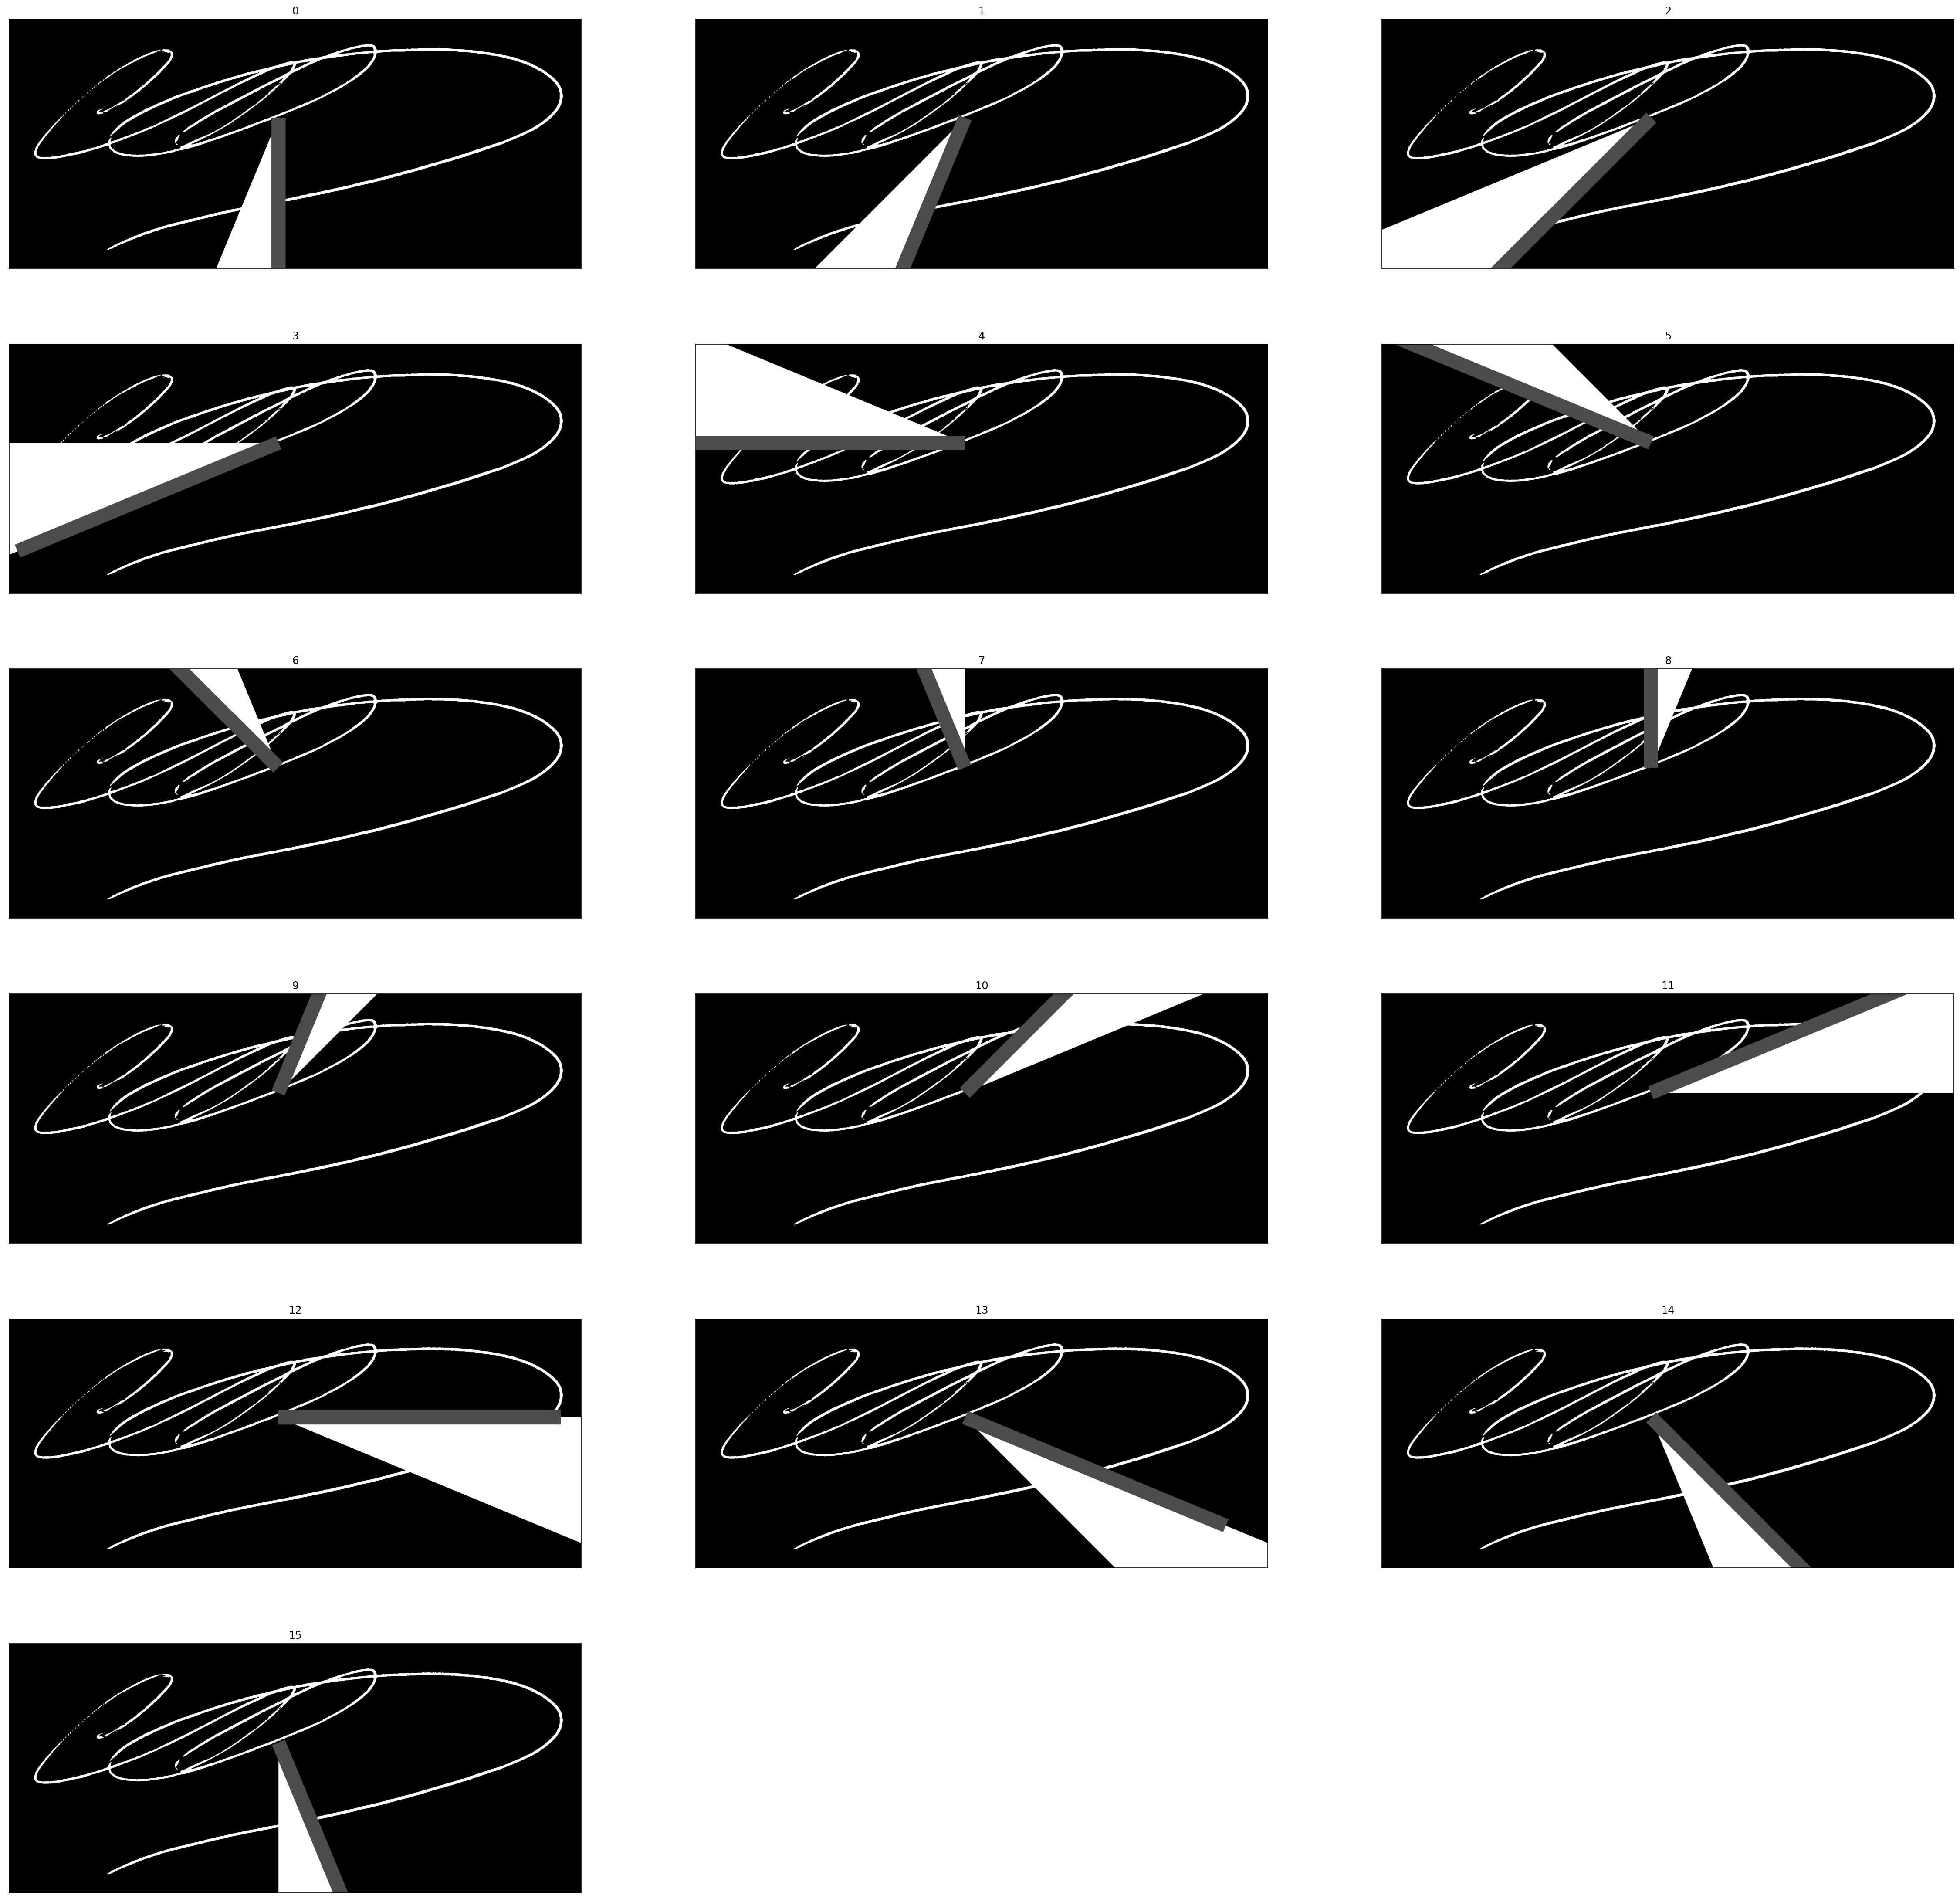

In [40]:
""" Show the image division grid. """
images = []
titles = []
for idx_to_modify in range(grid.N_divisions):
    np_img_copy = grid.npimg.copy()
    np_img_copy[grid.angs==idx_to_modify]=255
    img = Image.fromarray(np_img_copy)
    mark_img_line(img, grid.center, grid.center + (grid.idx_to_vector_end[idx_to_modify]-grid.center)*1000,w=50 )
    images.append(img)
    titles.append(idx_to_modify)
titles, images = zip(*sorted(zip(titles, images)))

plot_images_grid(images,width=3, titles=titles, figsize=(40,40))

En la imágen de abajo visualizamos la imágenes graficando el centro de masa, las secciones y los centros de masa de cada una (así como una línea entre estos y el centro de masa total).

También imprimimos las features para corroborar que tienen números que más o menos esperaríamos (distancia del centro de masa de la sección al de la imágen, ángulo relativo al inicio de sección, cantidad de píxeles de firma).

idx_to_dist
(0, 314.8963693195226)
(1, 432.90173267371455)
(2, 640.0642427609627)
(3, 465.87346028156696)
(4, 394.11774836023545)
(5, 292.1128379495593)
(6, 158.97810534071982)
(7, 147.16017335672518)
(8, 172.91994716274968)
(9, 251.90588774054746)
(10, 355.6516683374535)
(11, 863.3731081271368)
(12, 716.0703889251473)
(13, 414.10640167974617)
(14, 314.4441165207252)
(15, 289.5765291930118)

idx_to_angle
(0, 12.109469965203266)
(1, 13.727154679822105)
(2, 4.529785039714852)
(3, 12.995101649877572)
(4, 9.85096323169582)
(5, 7.0153107874616225)
(6, 10.827816990802217)
(7, 10.79449658371146)
(8, 12.220999427064205)
(9, 13.43922721432526)
(10, 13.711154006690284)
(11, 11.2468898556793)
(12, 8.871281738110214)
(13, 9.219458311086159)
(14, 10.330267429205641)
(15, 10.959767128121669)

idx_to_pixel_count
(0, 1312.0)
(1, 2450.0)
(2, 2040.0)
(3, 13010.0)
(4, 8600.0)
(5, 4029.0)
(6, 1998.0)
(7, 1711.0)
(8, 2240.0)
(9, 2637.0)
(10, 7452.0)
(11, 5475.0)
(12, 5341.0)
(13, 2303.0)
(14, 1388.0)
(15, 

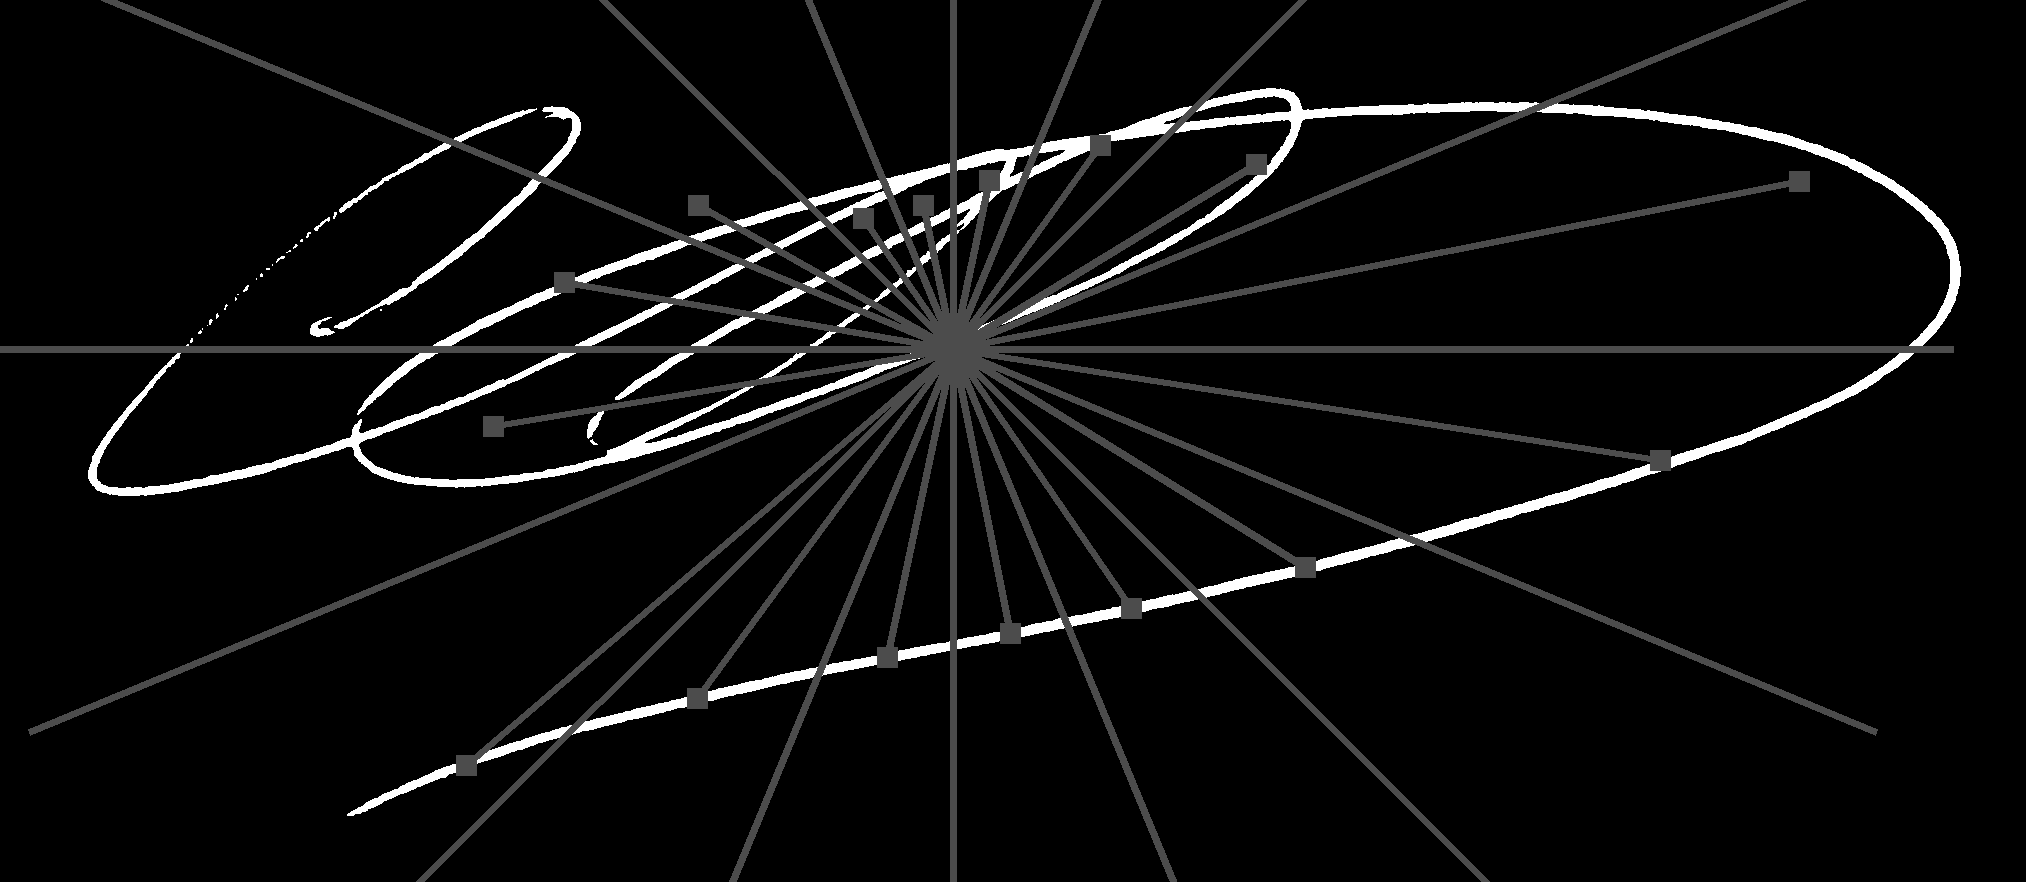

In [41]:
""" Show THE center + each division center + idx_to_dist + idx_to_vector_end + idx_to_angle """
def show_grid_data(gdata):
    img = Image.open(gdata.image_fp)
    mark_img(img, gdata.center[0], gdata.center[1], w=15)
    for idx in range(grid.N_divisions):
        mark_img(img,gdata.idx_to_center[idx][0],gdata.idx_to_center[idx][1],w=10)
        mark_img_line(img, gdata.center, gdata.idx_to_center[idx])
        mark_img_line(img, gdata.center, gdata.center + (gdata.idx_to_vector_end[idx]-gdata.center)*1000 )
        
    
    print("idx_to_dist")
    print('\n'.join(map(str,enumerate(list(gdata.idx_to_dist)))))
    print("\nidx_to_angle")
    print('\n'.join(map(str,enumerate(list(gdata.idx_to_angle*180/pi)))))
    print("\nidx_to_pixel_count")
    print('\n'.join(map(str,enumerate(list(gdata.idx_to_pixel_count)))))
    
    return img

show_grid_data(grid)

Imprimimos los dos puntos mas distantes de la firma. Esto es utilizado para calcular el radio de la firma, utilizado en la tesis de Marianela. Nuestro algoritmo lo hace calculando y considerando sólo los puntos de la cápsula convexa. Lo que optimiza mucho el tiempo debido a que en general los puntos de una firma no pertenecen a ella.

('R dist: ', 1883.9660294177281)


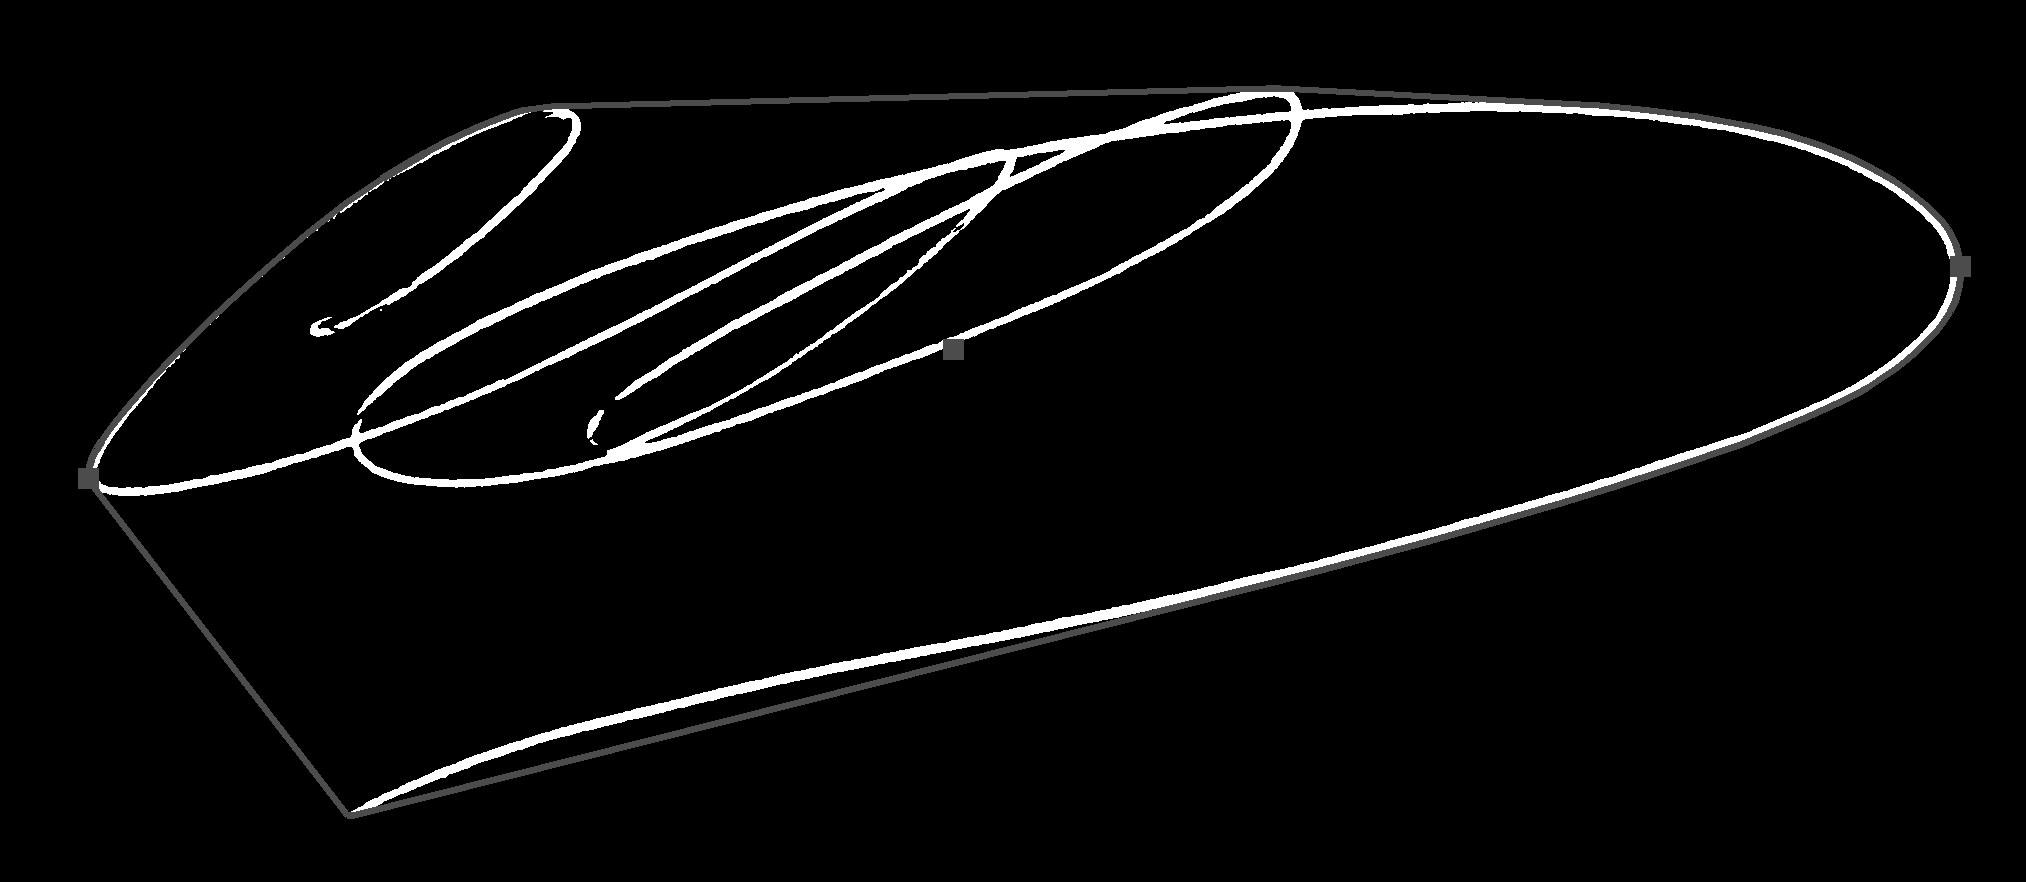

In [42]:
""" Show the CHULL + 2 farest point + distance between them """
def show_chull(grid):
    img = Image.open(grid.image_fp)
    for i in range(len(grid.chull_pts)):
        mark_img_line(img, grid.chull_pts[i-1], grid.chull_pts[i])
    print(('R dist: ', grid.R))
    mark_img(img,grid.farest[0][0],grid.farest[0][1], w=10)
    mark_img(img,grid.farest[1][0],grid.farest[1][1], w=10)
    mark_img(img,grid.center[0],grid.center[1],w=10)
    return img

show_chull(grid)

Utilizamos la clase GridData para guardar la data de la grilla en un archivo pkl.
Verificamos que la data de Grid se copia bien a GridData y que el proceso de guardar/cargar es correcto.

In [43]:
""" Check save/load GridData works ok. """
grid.save('./features22.pkl')
lgrid = FastGrid.load('./features22.pkl')
lgrid.__getstate__()==grid.__getstate__()

True

Con este código extraeríamos las features de nuestro dataset preprocesado. Es mejor utilizar *parallel_process_job*, porque es un proceso que dura mucho.

In [17]:
print(('N_divisions:', grid.N_divisions))
print(('R:', grid.R))
grid.features()

('N_divisions:', 16)
('R:', 1600.7029705726168)


(3, 16)

# Dataset de características

In [56]:
fns,X=load_features('sigcomp2009',32)
len(fns), X.shape

(1000, (1000, 3, 32))

In [57]:
train = fns.map(lambda x : 'NFI' in x)

In [58]:
fns=fns[train]
X=X[train]
len(fns), X.shape

(940, (940, 3, 32))

In [59]:
y = fns.map(Path).map(ds_sigcomp2009.get_y)
vocab = {t:i for i,t in enumerate(set(y))}
y = np.array(y.map(lambda x : vocab[x]))
y

array([18, 19, 40, 23, 56, 61, 75, 22, 74, 14, 20, 15, 71, 35, 11,  1, 56, 47, 15, 24, 51,  3, 39, 30, 32, 40, 44, 29, 23, 44, 38, 74, 22, 46, 56, 66, 12, 50, 69, 17, 70, 53, 35, 13, 68, 69, 71, 19,
       64, 46, 65, 26,  3, 74, 76, 28, 61, 40, 21, 77,  1, 29, 16, 25, 77, 75, 21, 32, 34, 61, 57, 35, 53, 50, 31, 67, 64, 55, 37,  4, 47, 63, 75, 54, 23, 66, 76, 45, 31, 36, 73, 78, 15, 48, 13, 26,
       65, 37, 34, 16,  2, 40, 27, 66, 28, 22, 70,  8, 11, 61, 13, 67, 70, 40,  8, 24, 46,  8, 56, 71, 62, 47, 60, 66, 45, 53, 75, 60, 78,  6, 13, 17,  4, 62, 78, 62, 54, 31, 65, 19, 76, 72, 10, 39,
       56, 20, 62, 45, 30, 13, 13, 13, 48, 64, 10, 72, 20, 43, 53, 41, 18, 63, 71,  9, 30, 42, 72,  9,  7, 20, 29, 22,  2,  5,  8, 60,  1, 42, 77, 62,  4, 14, 47, 11, 46, 34, 16, 70, 56, 28, 21, 36,
       22,  5, 15, 71, 66, 61, 33, 39,  1, 75, 57,  7, 45, 67, 72, 18, 12, 12, 55, 60,  6, 40, 75, 47, 17, 43, 34, 51, 59, 58, 69, 57, 32, 74,  8, 60, 31, 66, 14, 16, 74, 67, 45, 56, 33, 44, 74, 50,
     

En la tesina de Marianela se propone aplicar DFT a cada vector de features para proveer robustez a la invariancia de a la rotación.

In [60]:
if FEATURE_FFT_ON: 
    X = np.abs(np.fft.fft(X))

## Data normalization

Al igual que \[TESIS-MARIANELA\] nuestas features tienen escalamientos teniendo en cuenta el radio de la firma y/o por la cantidad de diviones usadas para hacerlo independiente de estas magnitudes. Nosotros hemos hecho algo parecido (ver método features de clase FastGrid en *features_grid.py*). A la cantidad de píxeles la escalamos por (N_division / R^2) tratando de hacerla independiente de la superficie de la imágenes y la cantidad de divisiones; a la distancia entre centros de masa la dividimos por R tratando de hacerla independiente del tamaño de la imágen y al ángulo del centro de masa al inicio de la sección lo multiplicamos por N_division tratando de hacerla independiente de la cantidad de divisiones.

En \[TESIS-MARIANELA\] tenemos 3 features con unidades distintas (cantidad de píxeles, ángulos, distancia) por lo que sería razonable aplicar algún método de preprocesamiento (además que existen clasificadores que asumen normalización de los datos). En el marco teórico hemos explayado los métodos de normalización de datos aplicable a las features antes de enviarlas al clasificador. 

La distribución de los datos vemos que las dos primeras features (cantidad de píxeles por sección y distancia entre el centro de masa de la sección y de la firma) son distribuciones skewed.
No obstante aplicaremos StandardScaler ya que separan mejor estas distribuciones, haciéndo que sea más fácil de aprender con métodos como SVM.


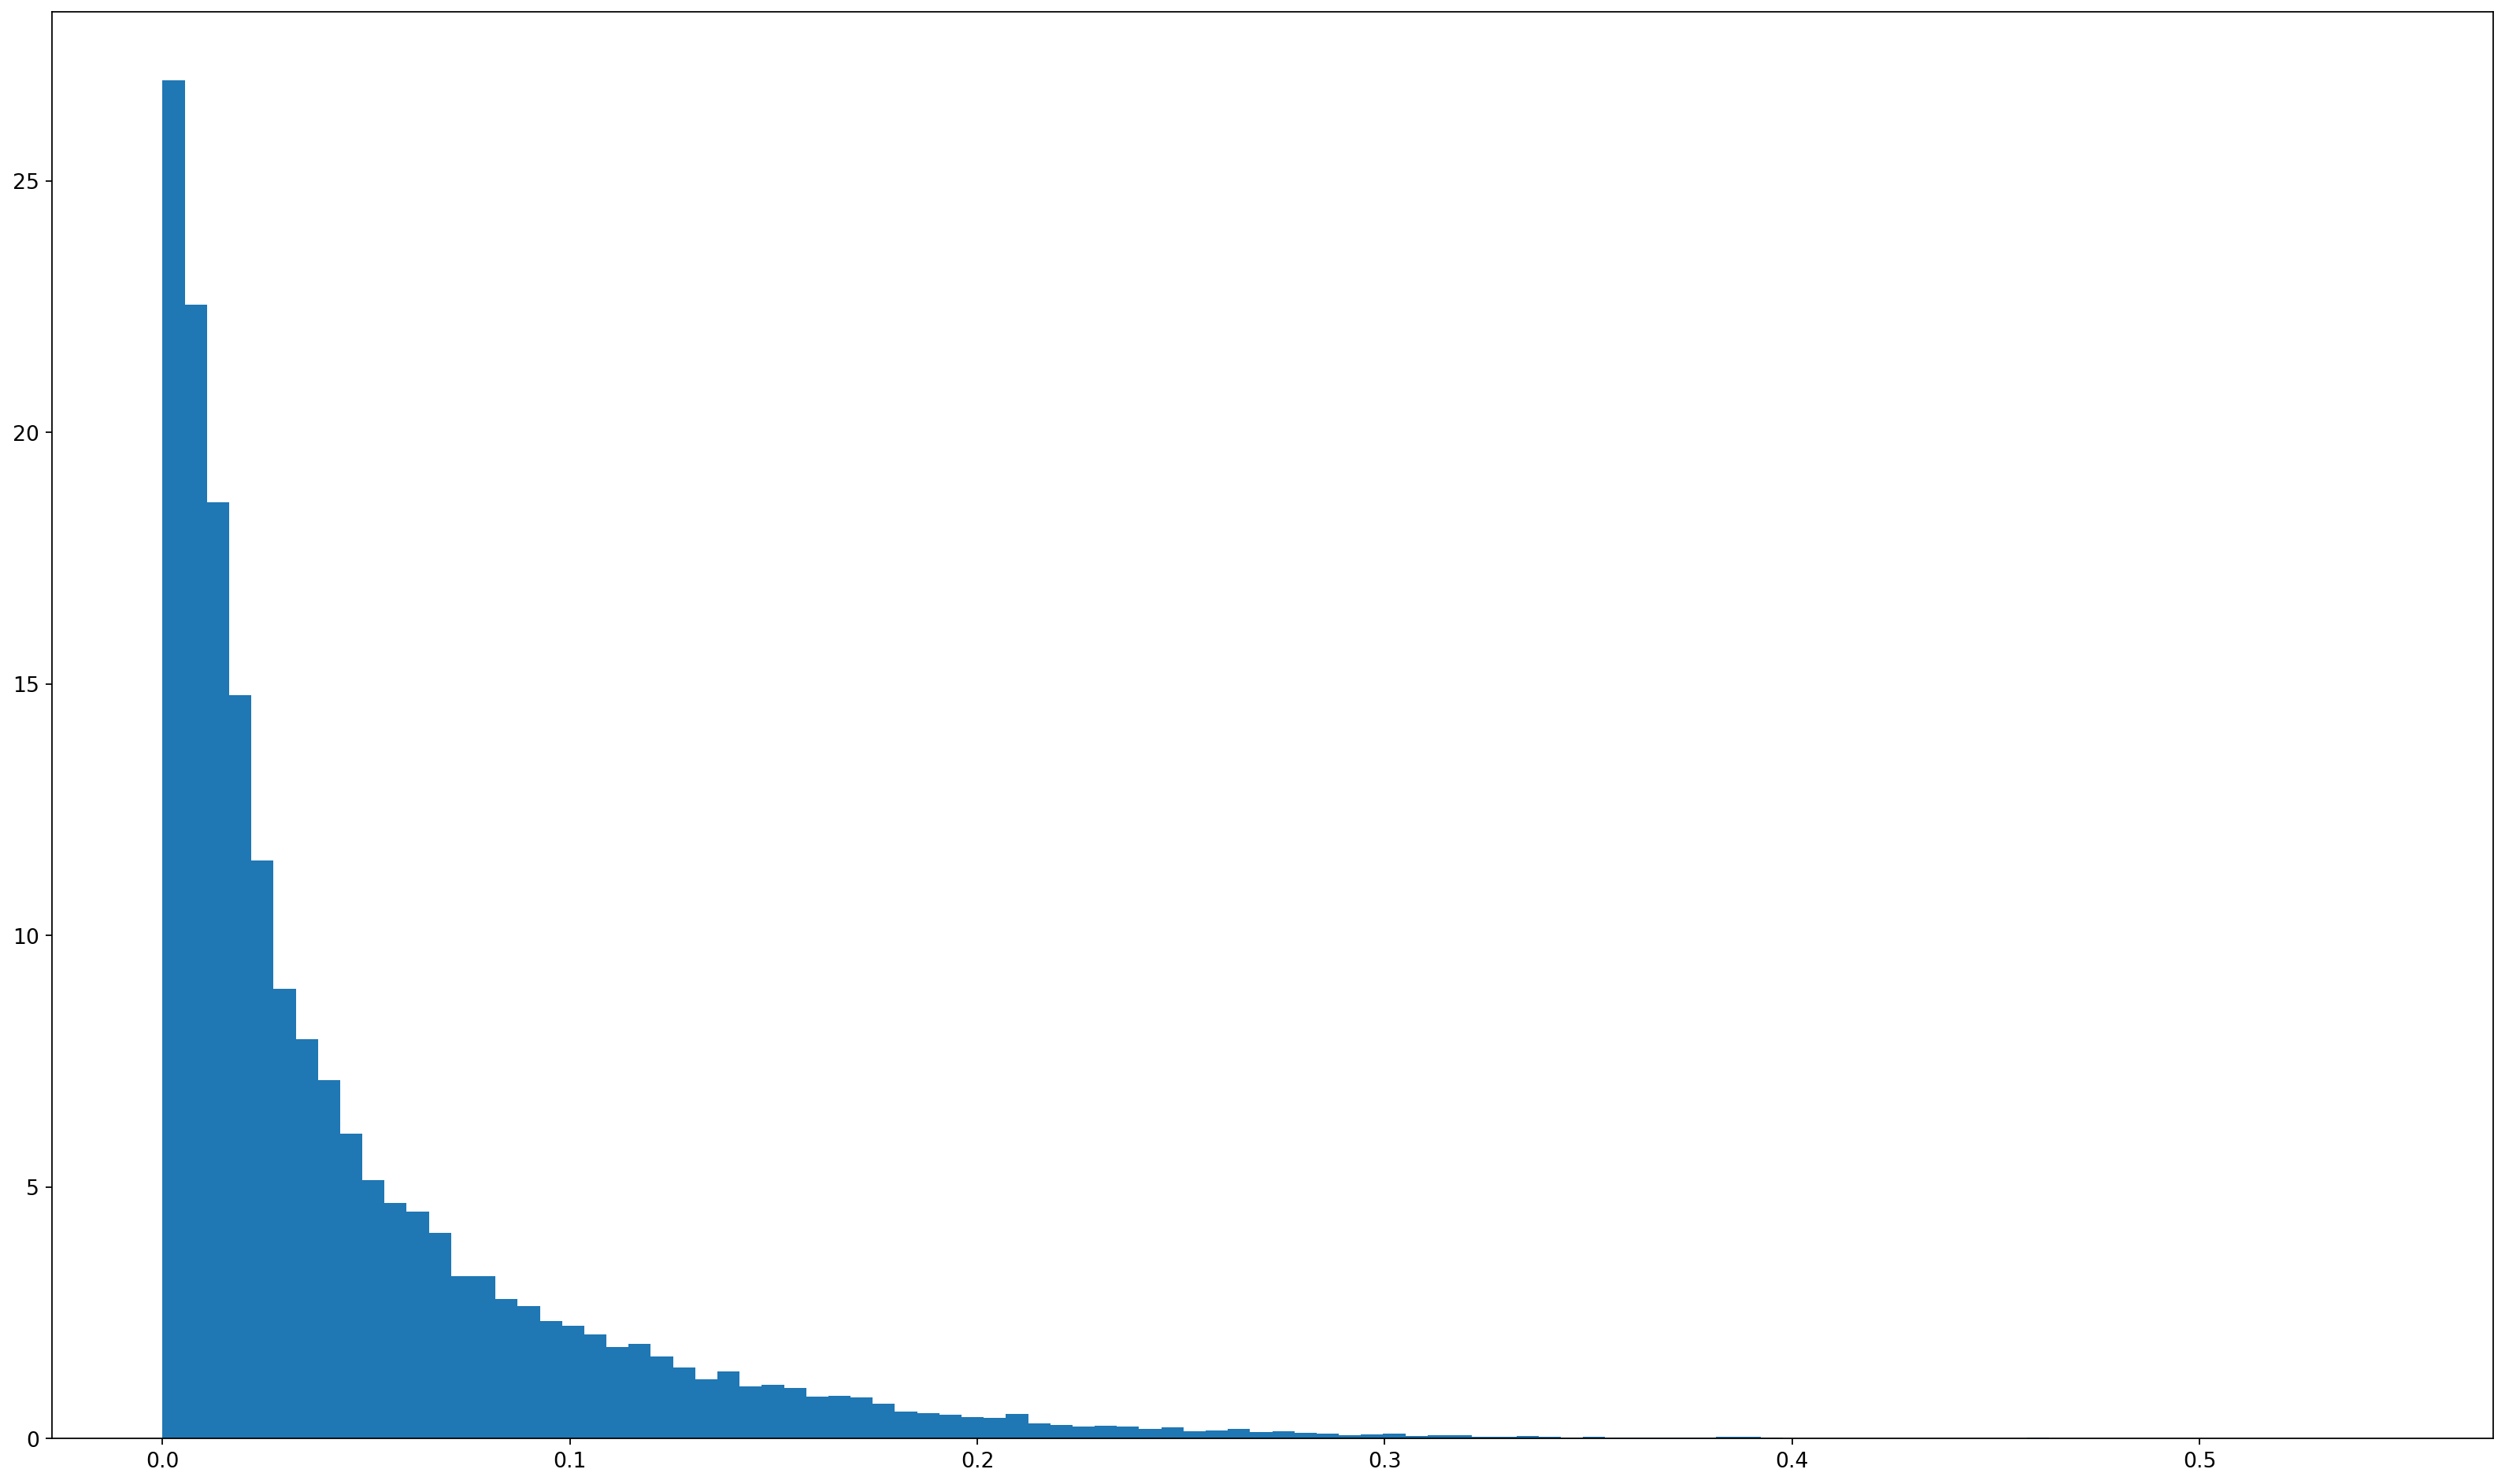

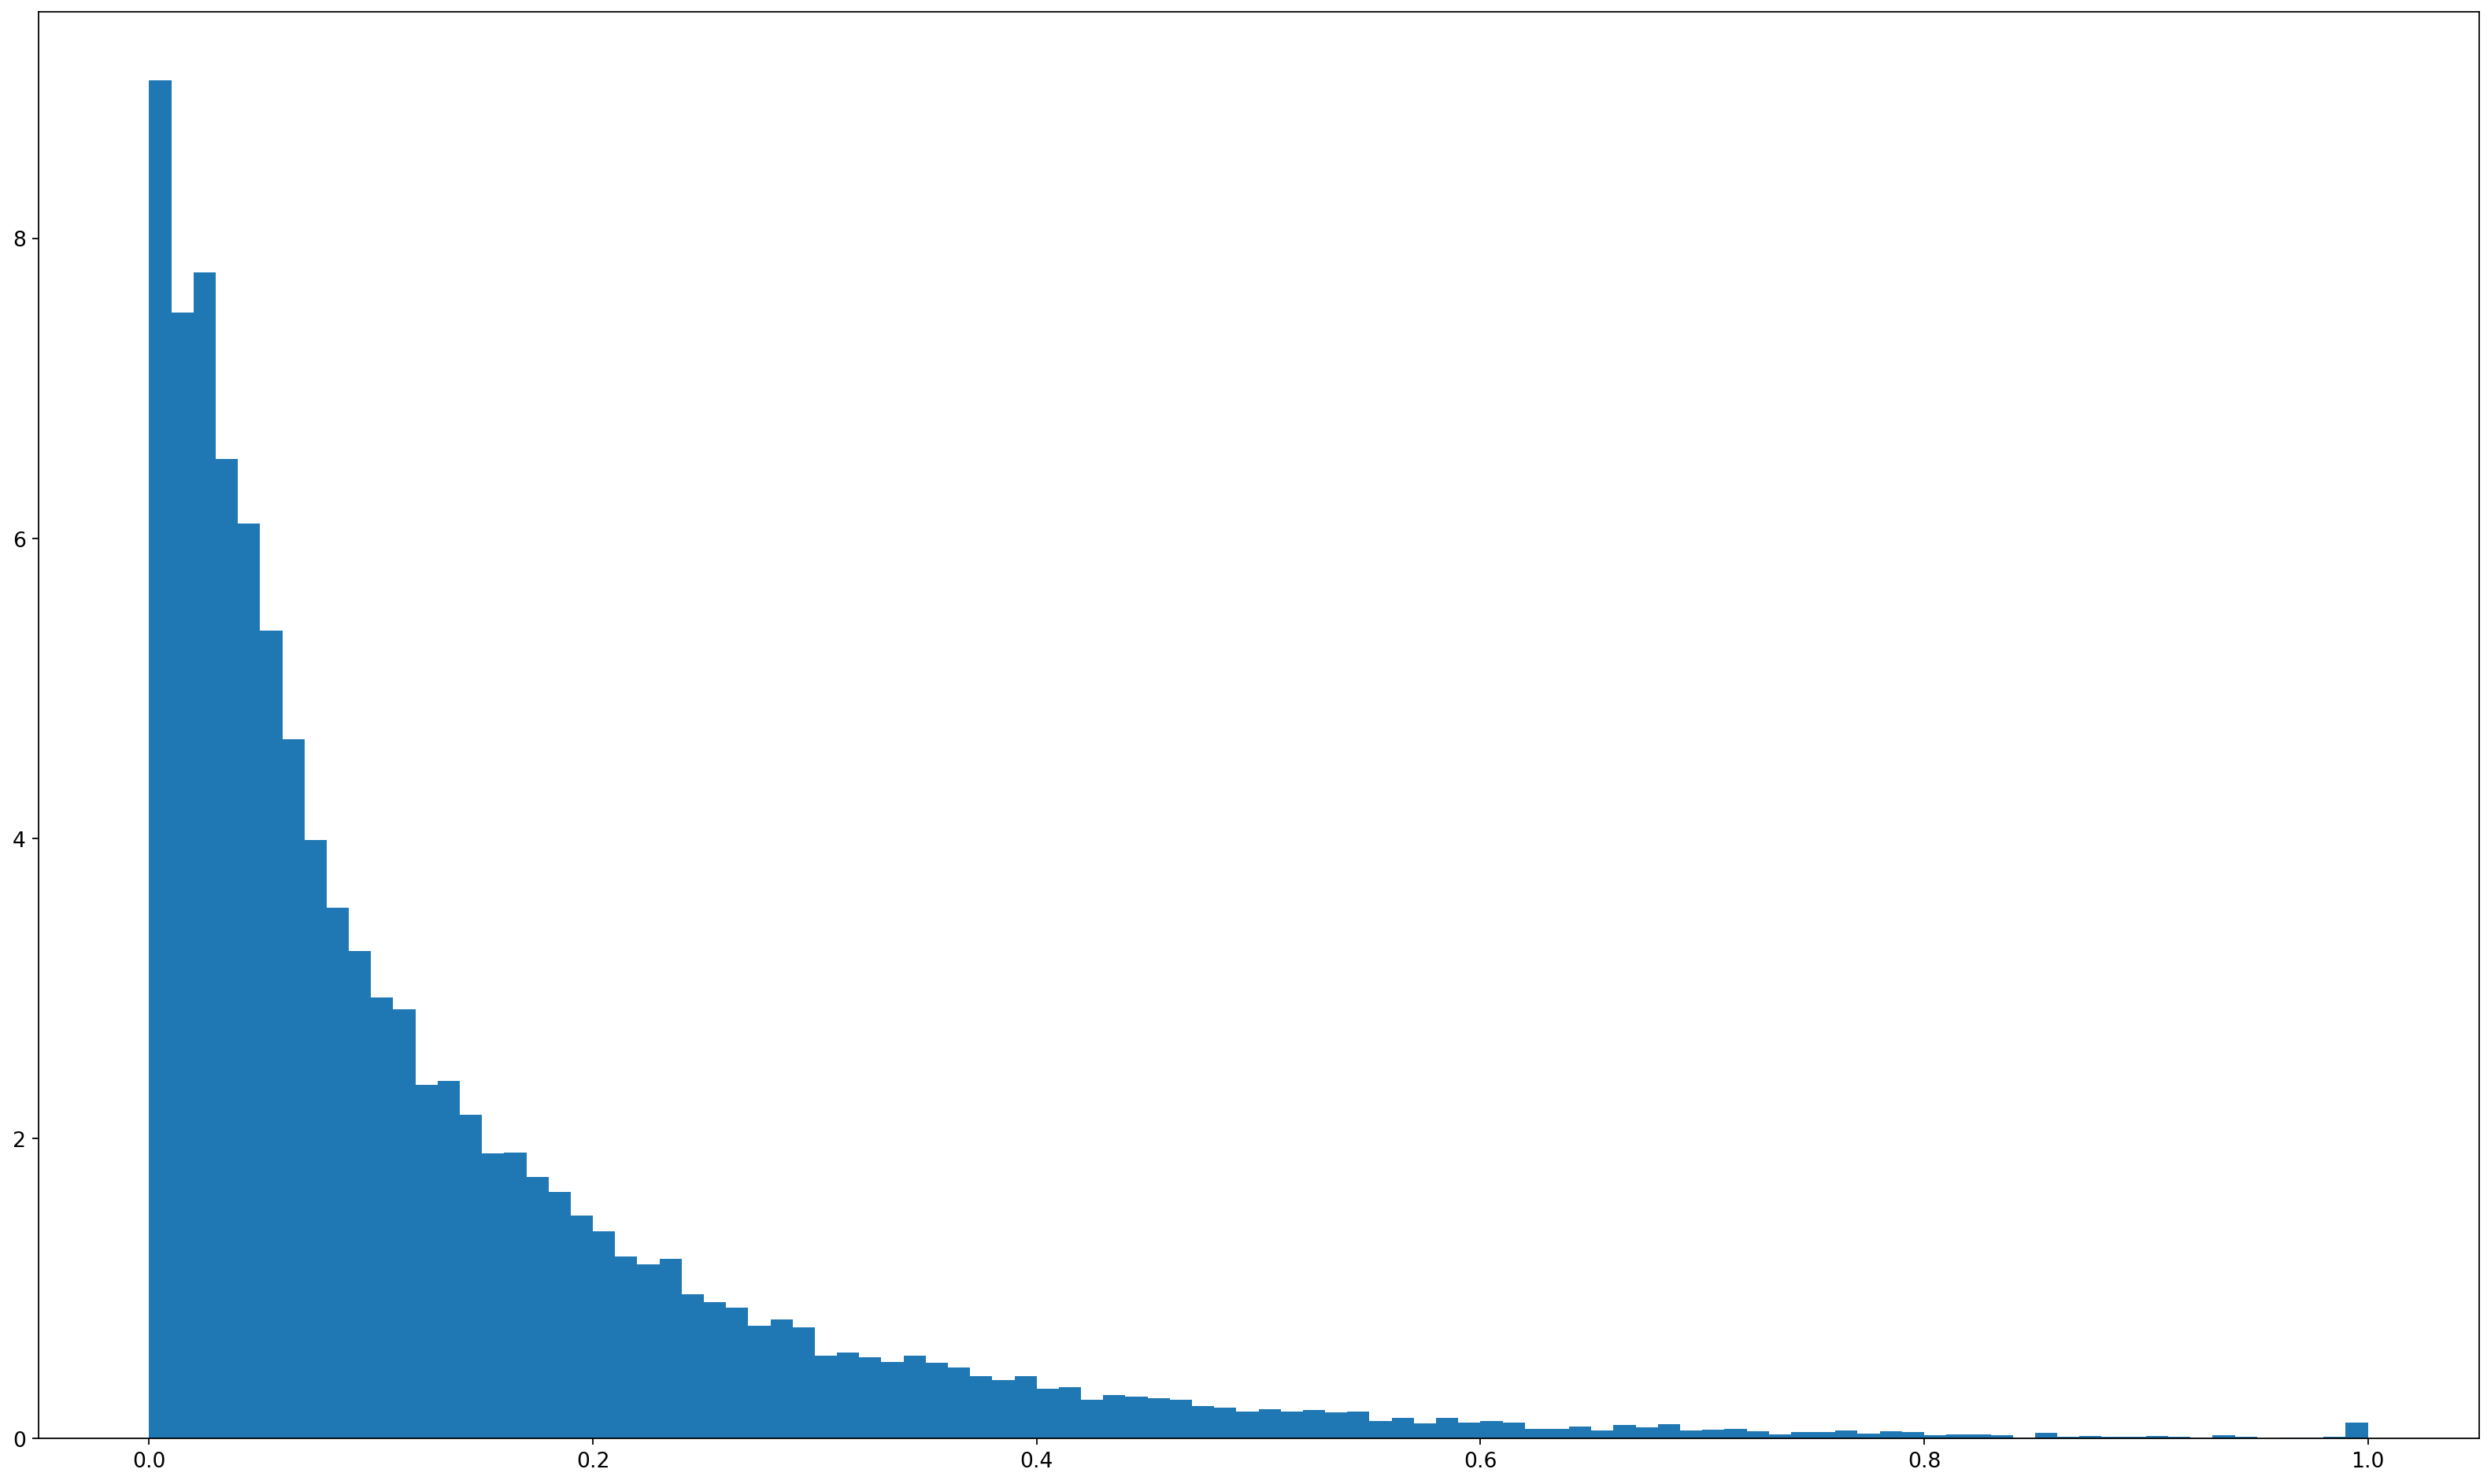

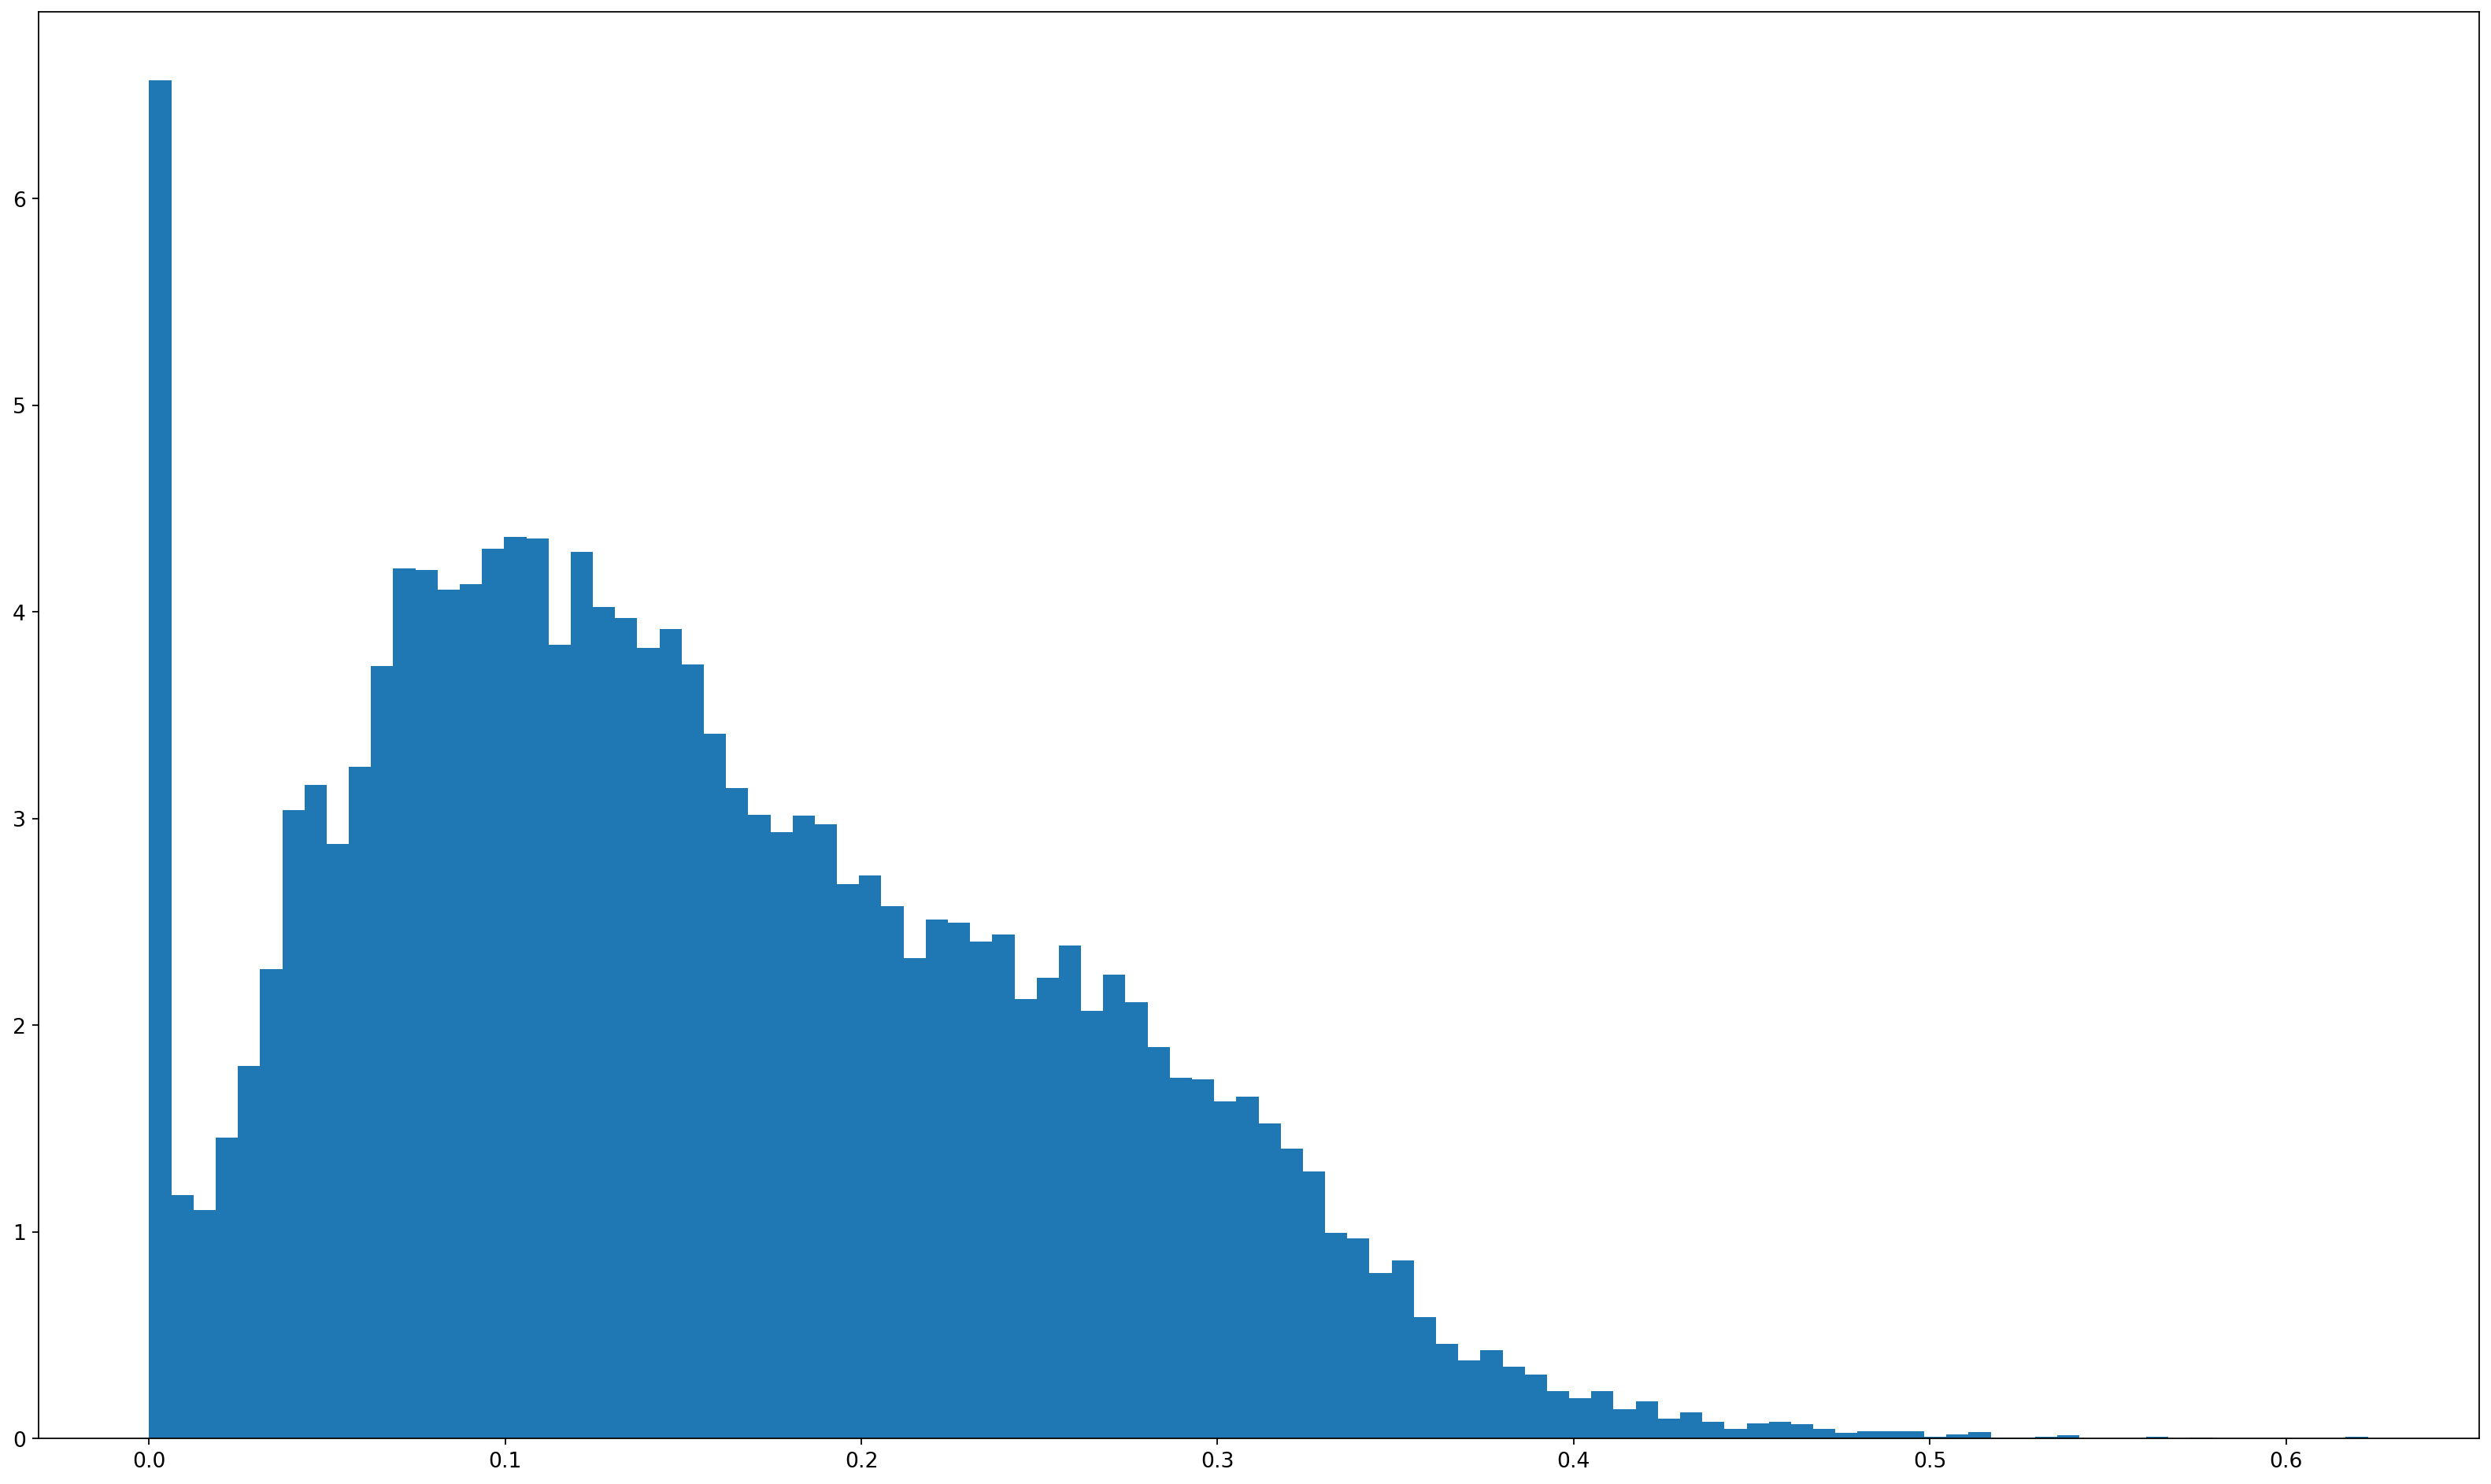

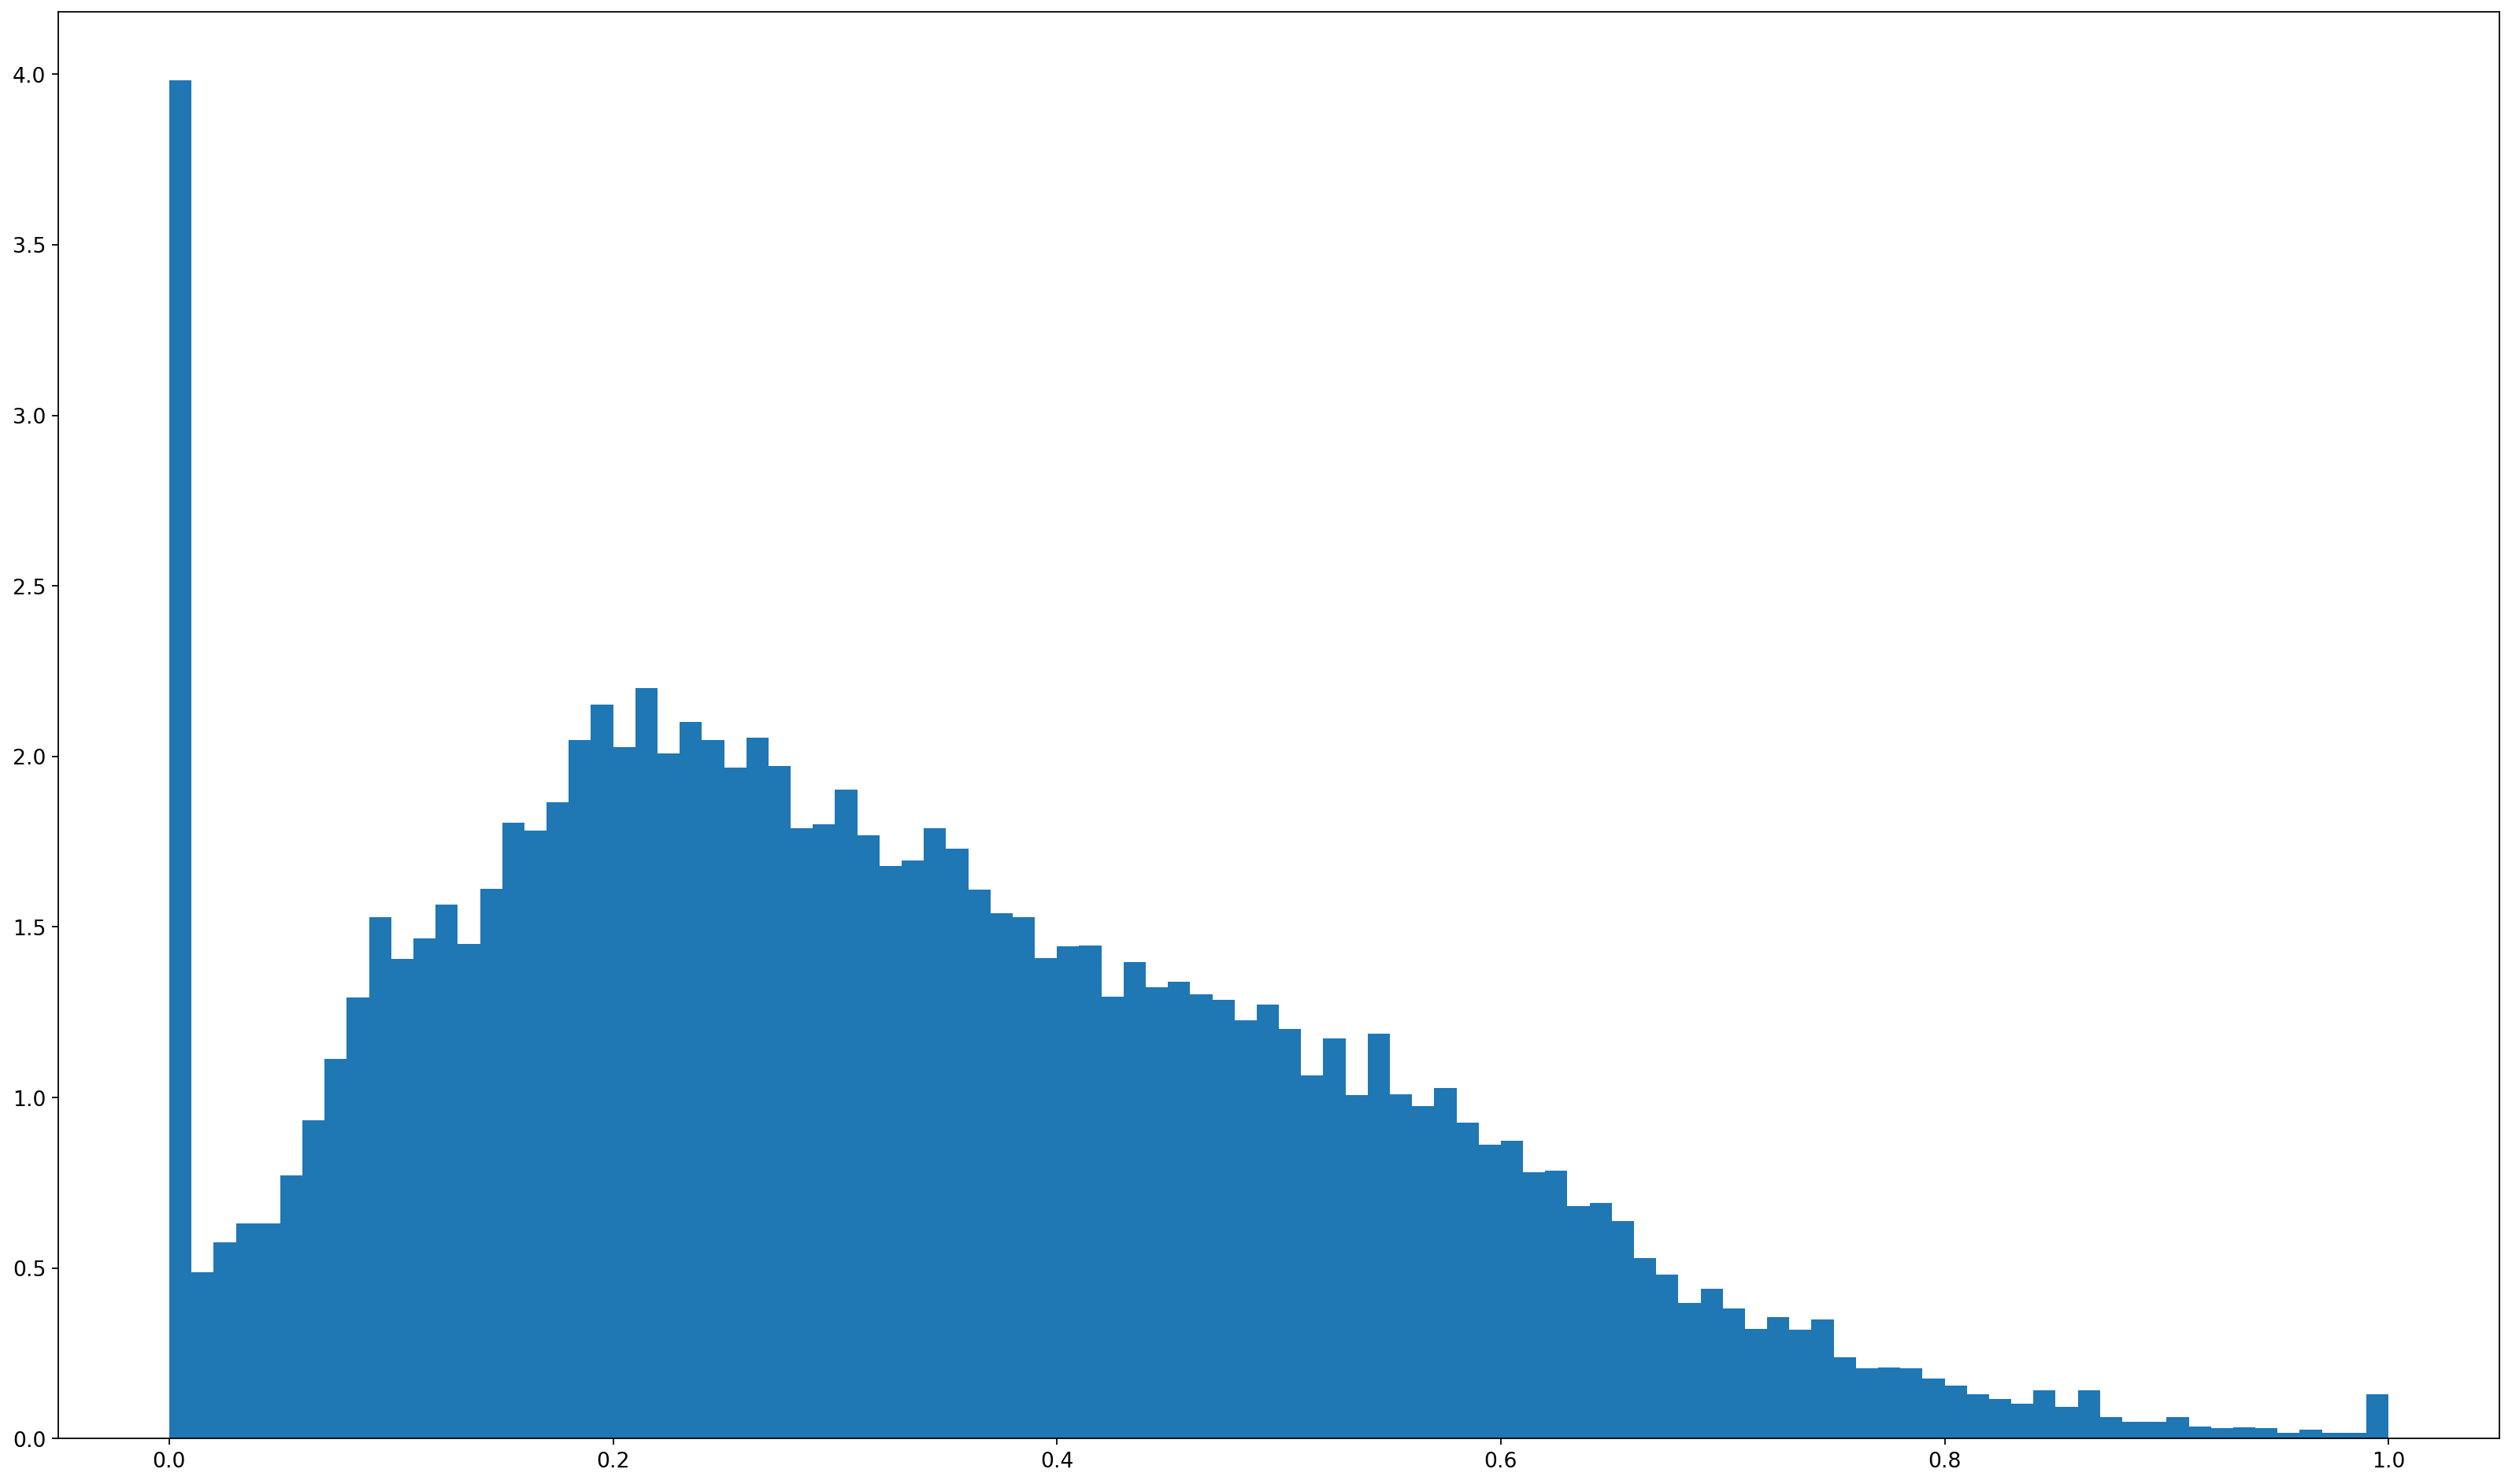

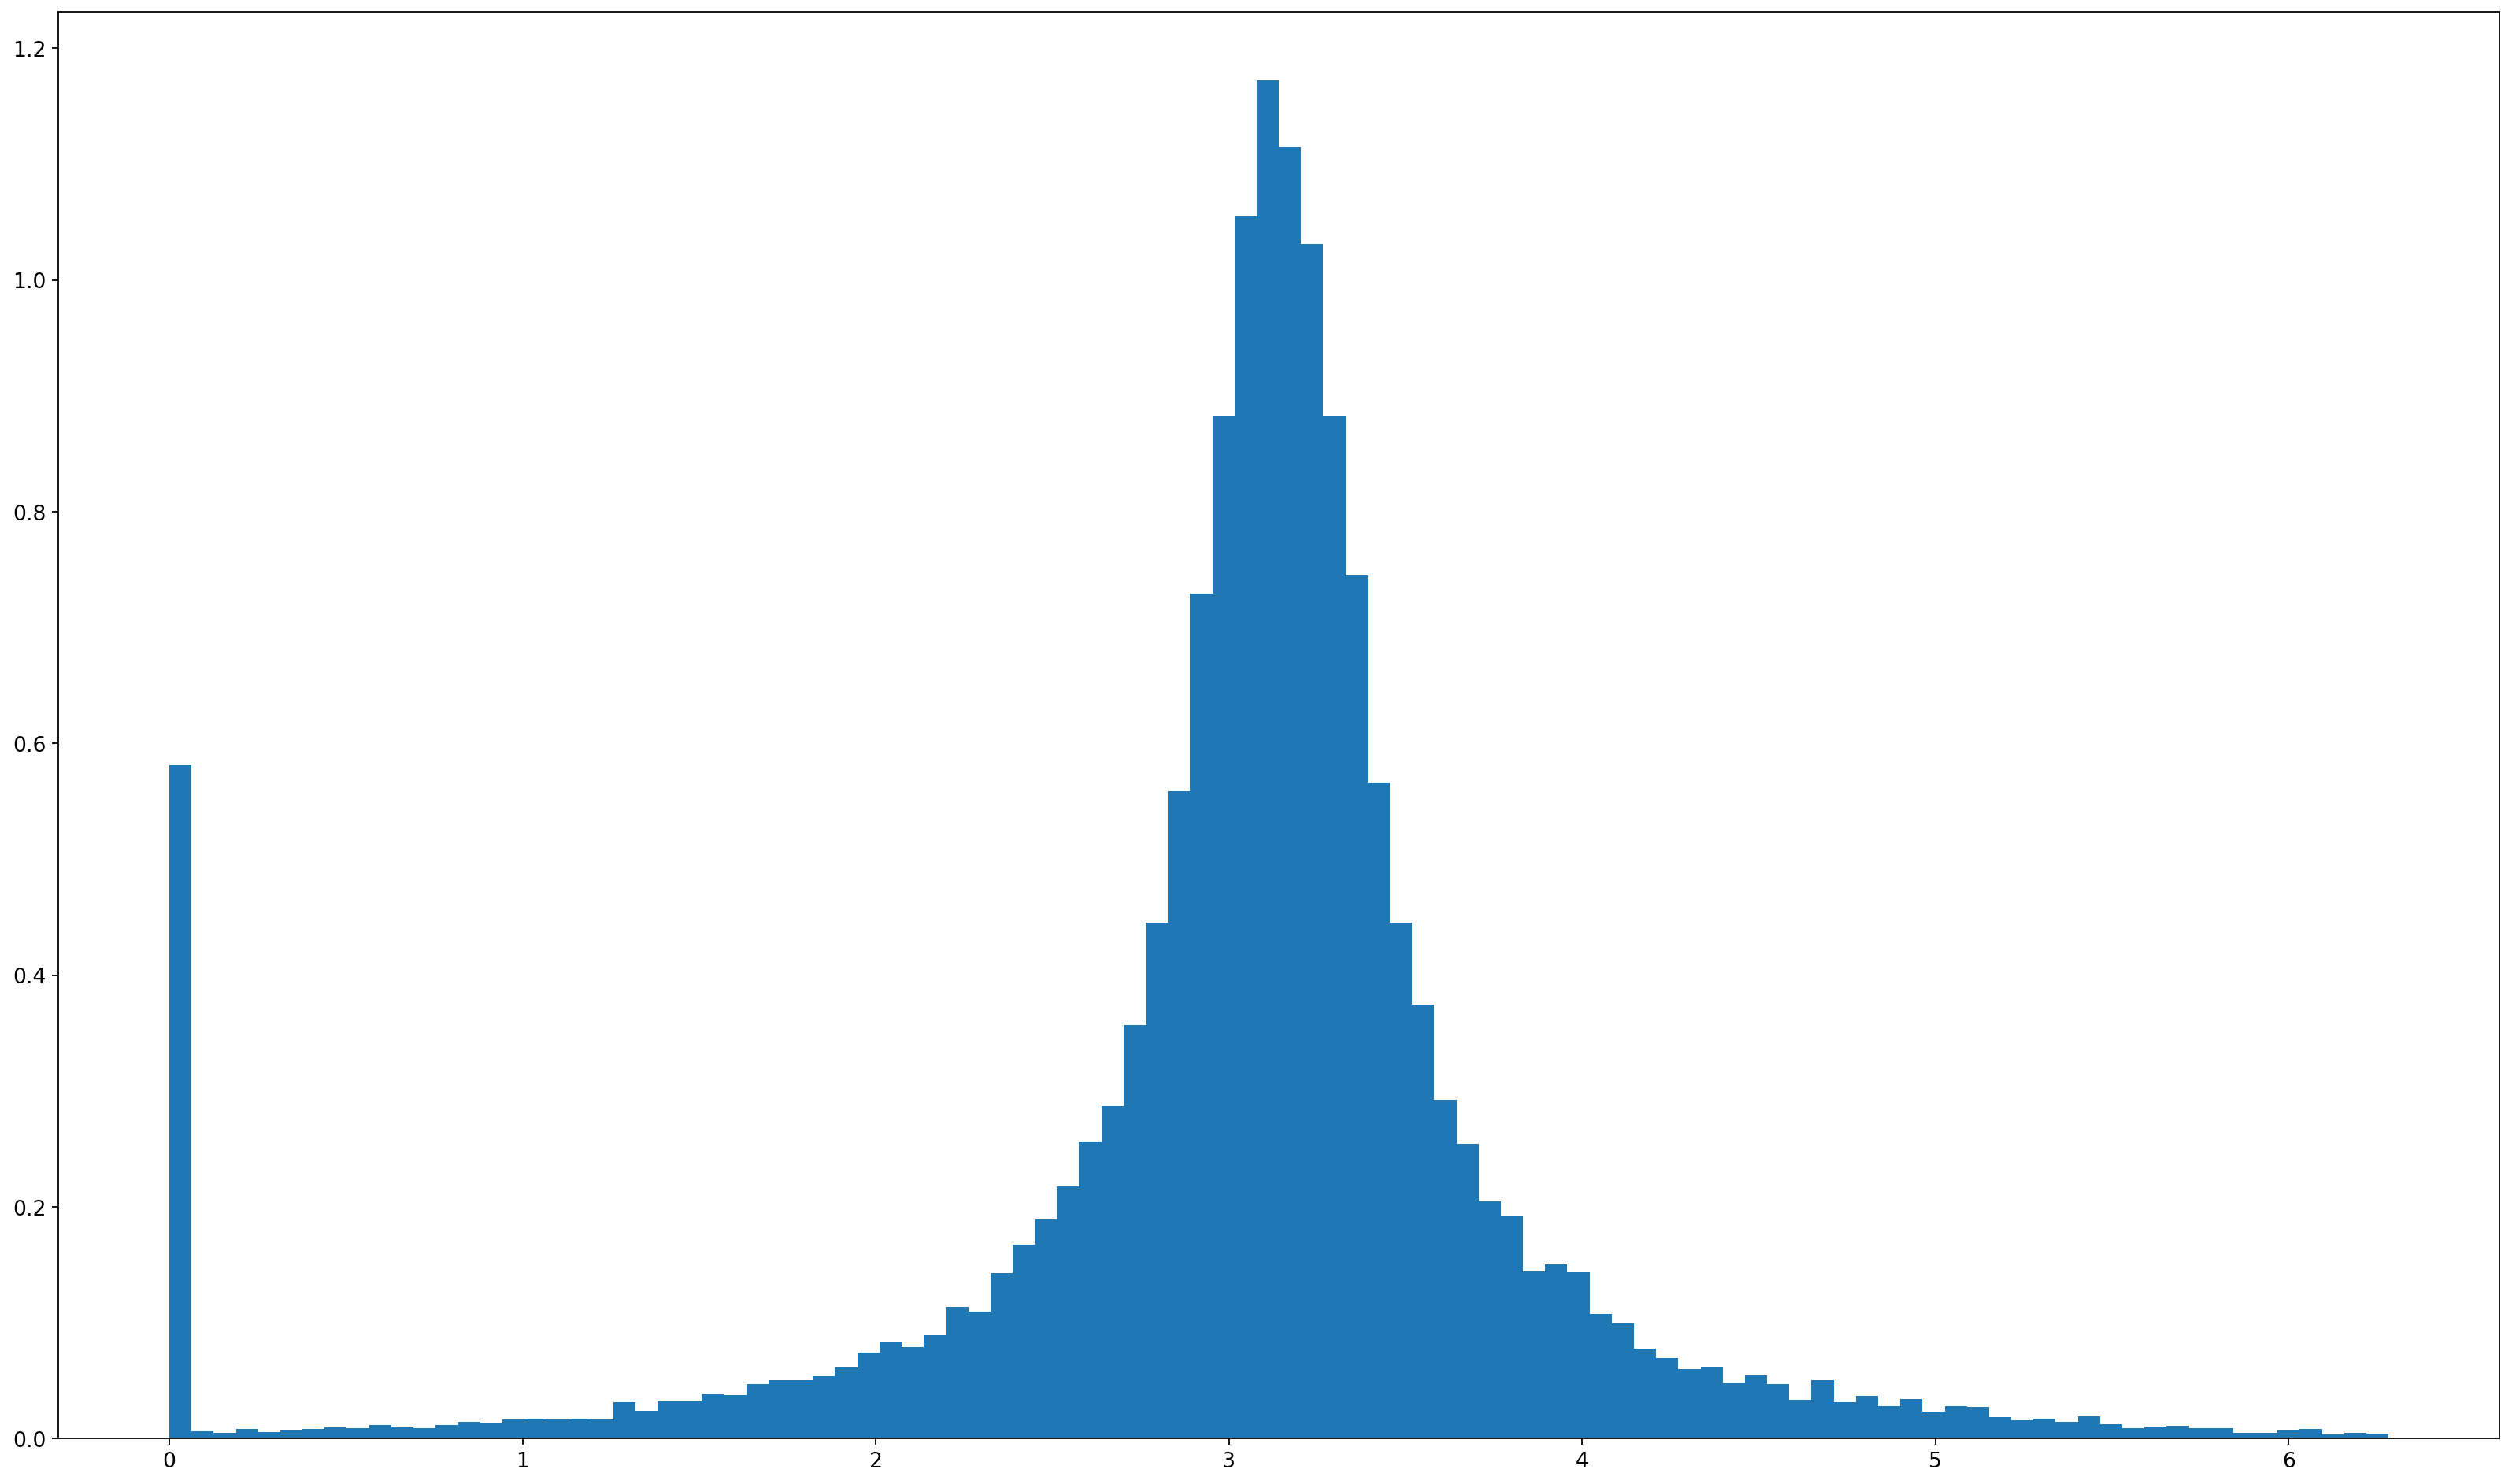

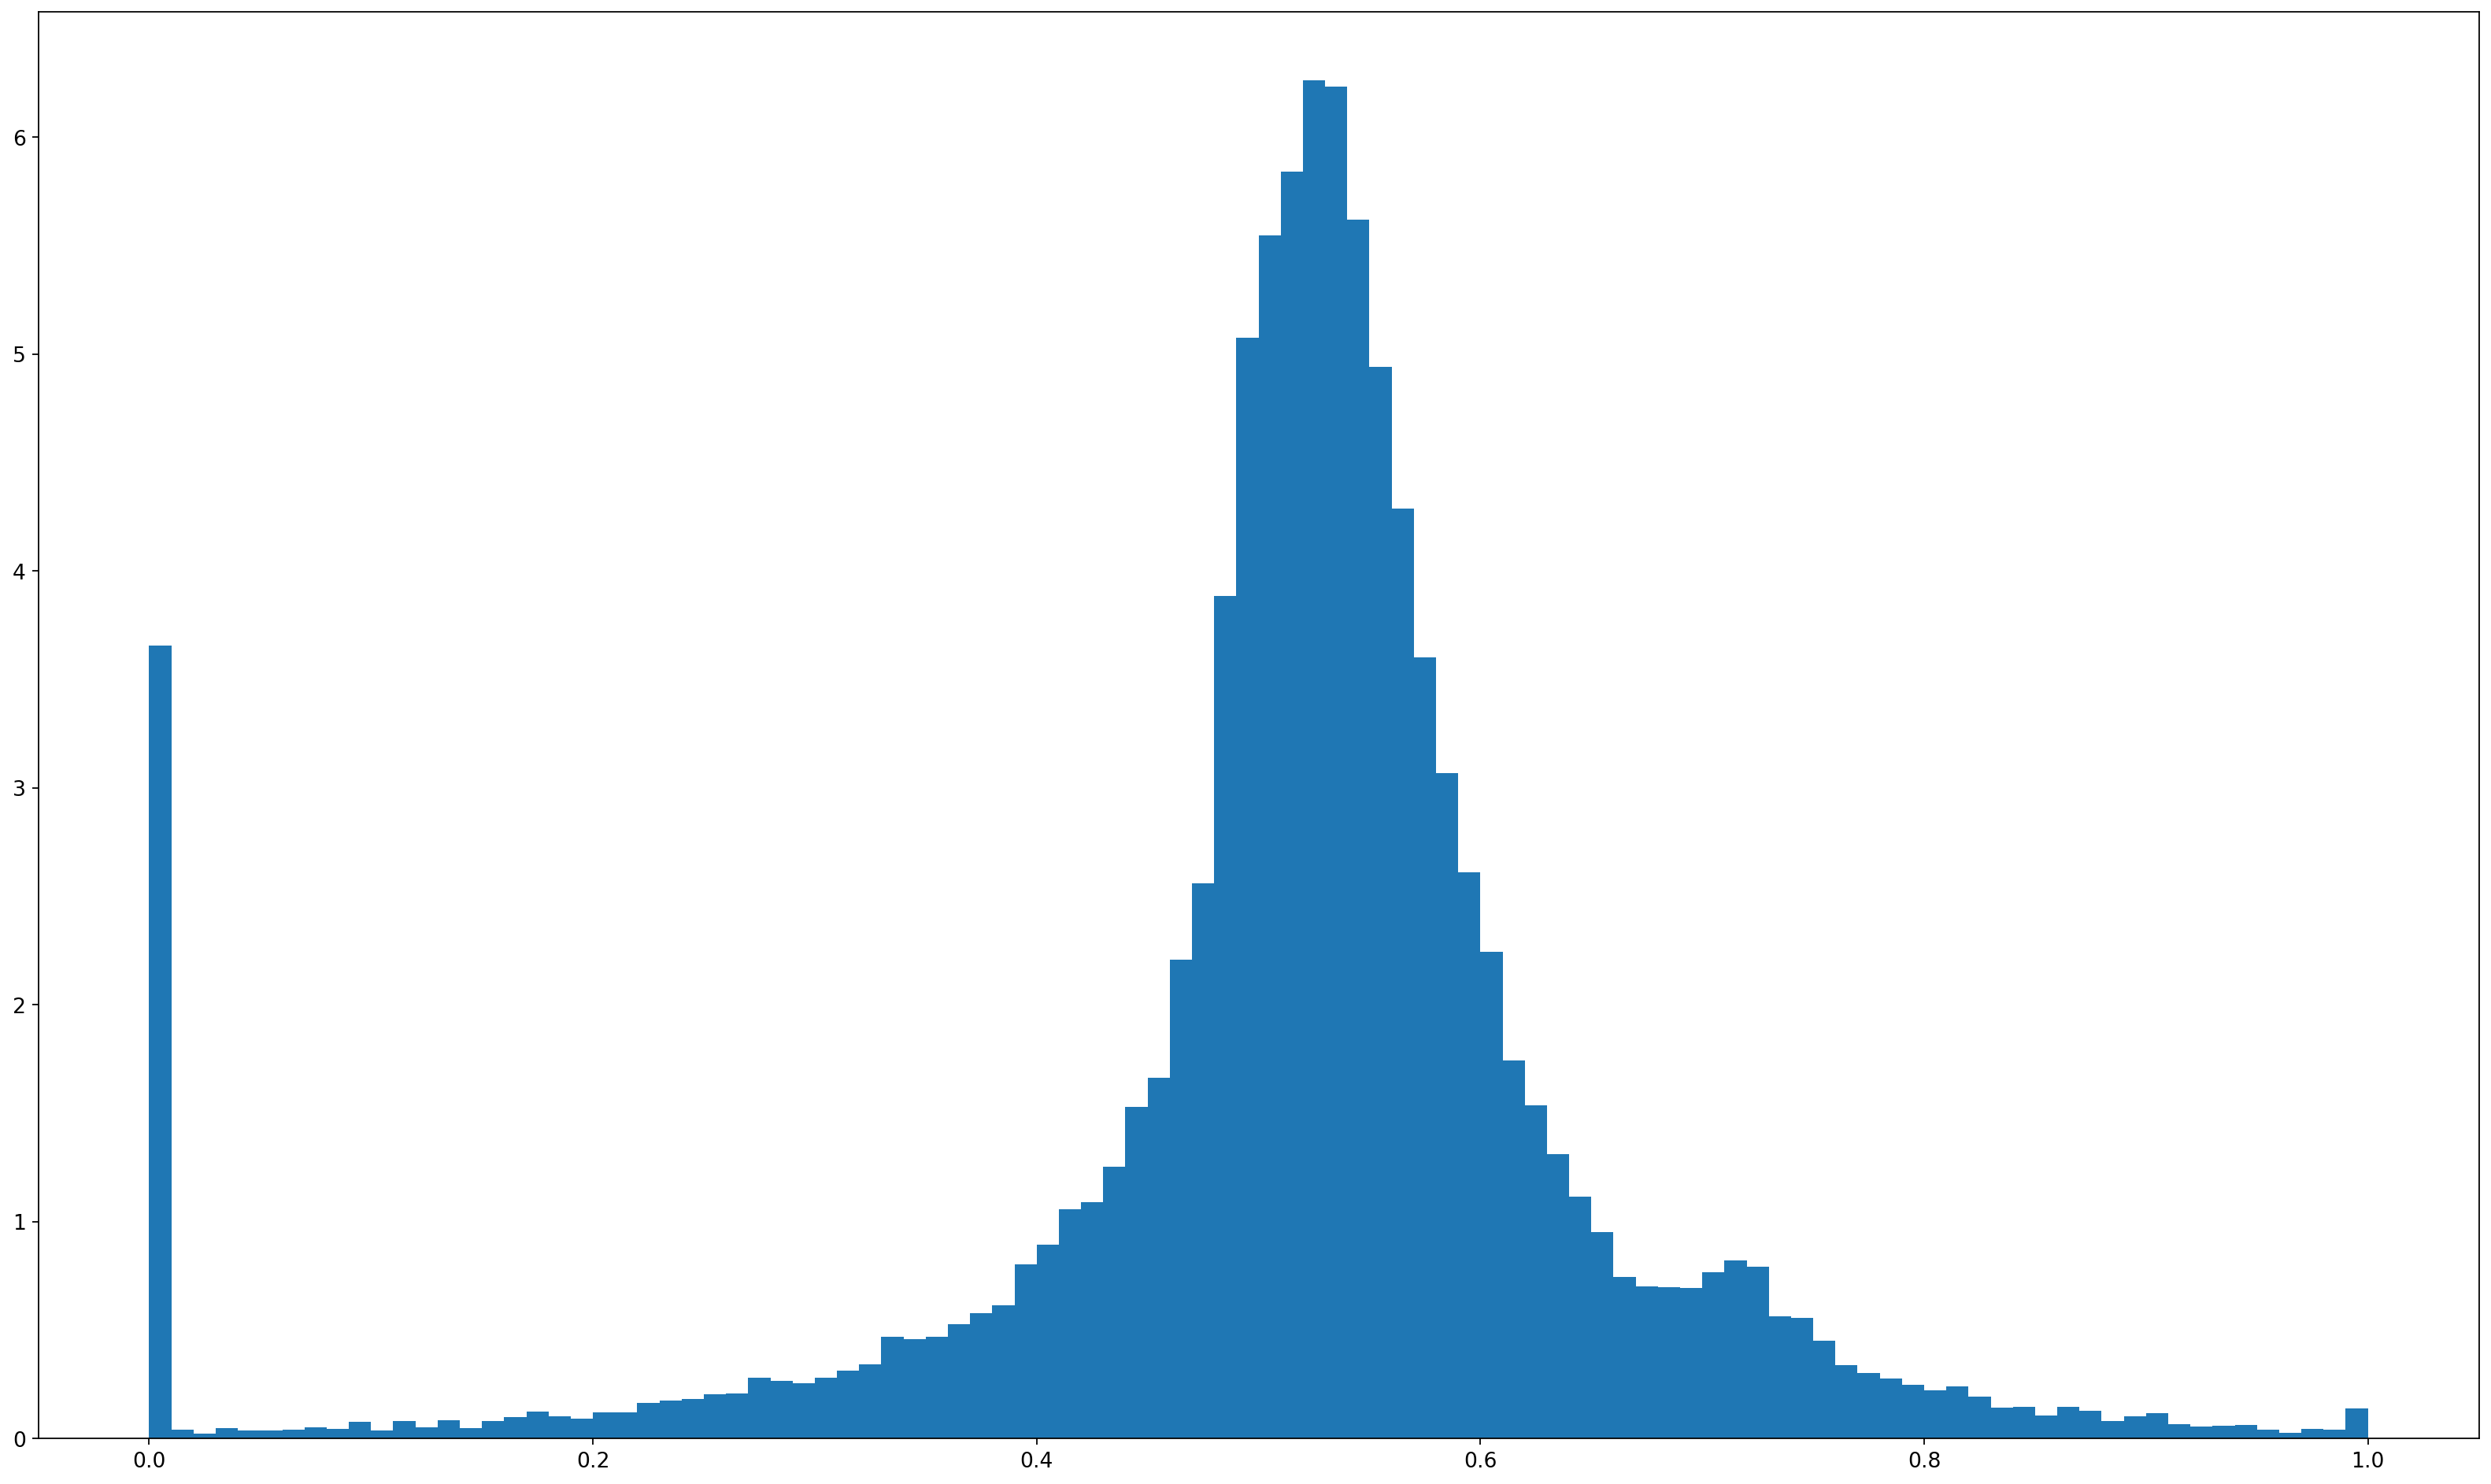

In [61]:
""" Creates scalers and fit them for normalization. Show data distribution before/after normalization. """
def plot_hist(data):
    plt.figure(figsize=(25, 15), dpi=80)
    plt.hist(data.flatten(),density = True, bins = 100)
    plt.show()

#scalers = [ StandardScaler() for _ in range(X.shape[1]) ]
scalers = [ MinMaxScaler() for _ in range(X.shape[1]) ]

for i in range(X.shape[1]):
    data = X[:,i,:]
    plot_hist(data)
    scalers[i].fit(data)
    plot_hist(scalers[i].transform(data))

In [62]:
Xn = np.array([ scalers[i].transform(X[:,i,:]) for i in range(X.shape[1])])
Xn = np.moveaxis(Xn,0,1)
Xn.shape

(940, 3, 32)

# PCA para visualizar y entender los datos

El análisis de componentes principales nos puede ser últil para, reduciendo la dimensionalidad de los datos, visualizarlos y verificar ciertas propiedades. Podemos analizar tanto el dataset original (donde cada autor podría verse como una clase) como el dataset de nuestro problemas (pares de firmas y las clases son matcheos no matcheos).


## Visualización por autores

Visualizando cada firma y no pares de firmas y cada autor como una clase diferente podemos ver que:

- Las features elegidas en general clusterizan y separan las firmas.
- En el dataset de entrenamiento parece estar todo más separado, más fácil de diferenciar. Es bueno que el dataset de test sea desafiante.

/home/marian/Escritorio/tesina/siamess/visualization.py:60: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax =  plt.axes()


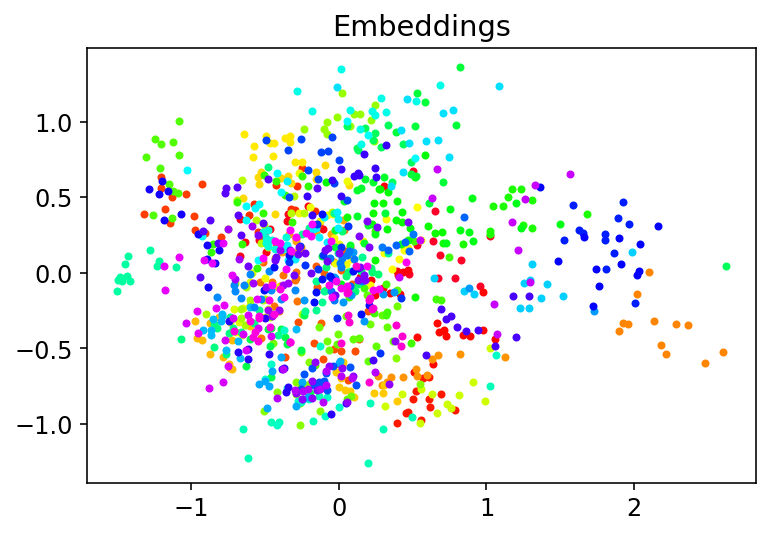

In [63]:
X2D = PCA(n_components=2).fit_transform(Xn.reshape((Xn.shape[0],-1)))
plotpca2d(X2D,y)

/home/marian/Escritorio/tesina/siamess/visualization.py:75: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes(projection='3d')


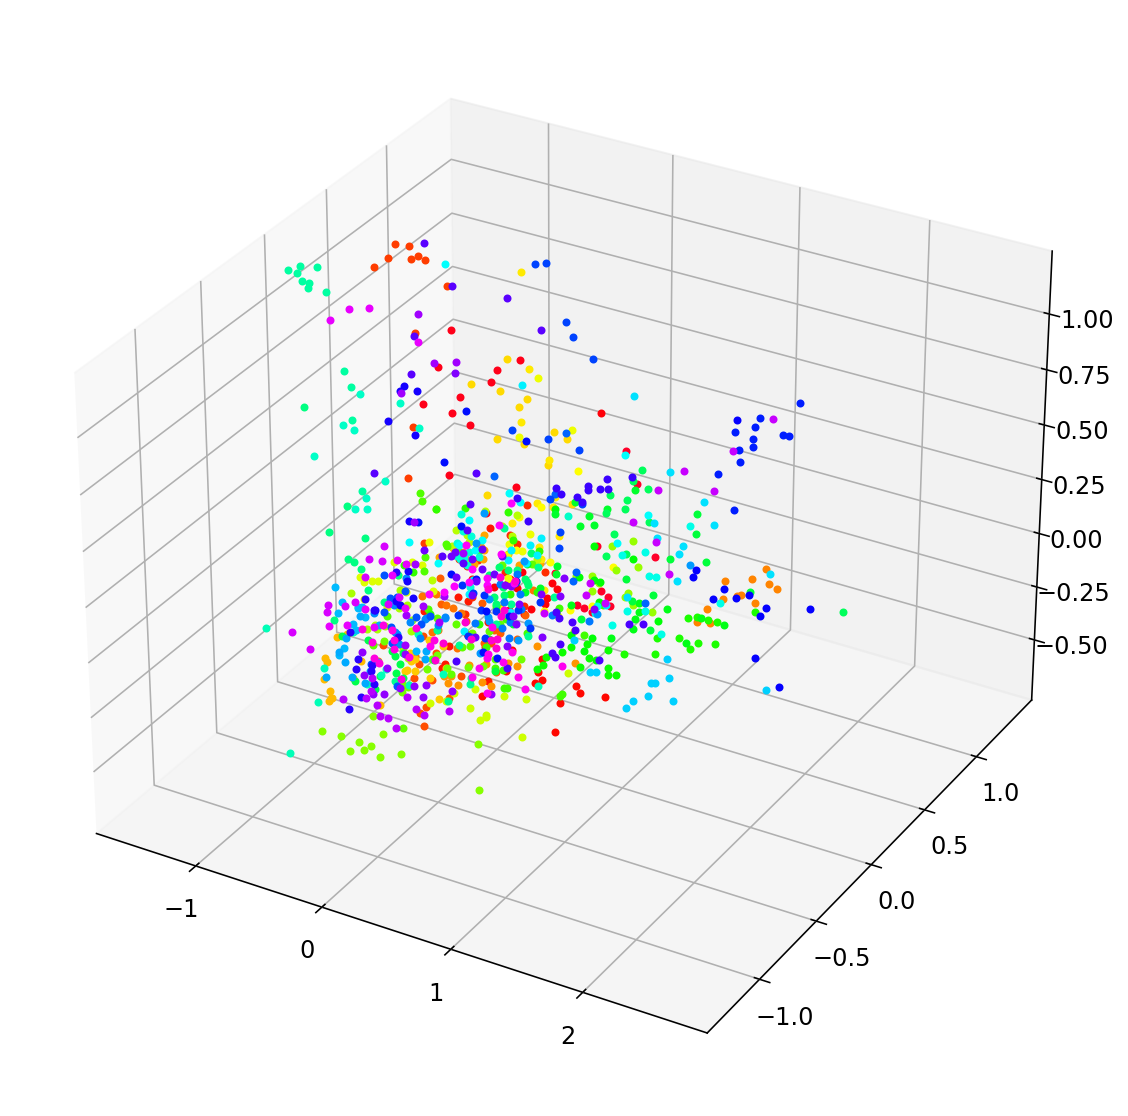

In [64]:
X3D = PCA(n_components=3).fit_transform(Xn.reshape((Xn.shape[0],-1)))
plotpca3d(X3D,y)

In [40]:
pca = PCA(n_components=2)
plot_2d_space(pca.fit_transform(ds.trainData), [not(x) for x in ds.trainLabel], '(2 PCA components)')

NameError: name 'ds' is not defined

## Visualización de 'matcheos', 'no matcheos'

A continuación vemos que las features de los 'matcheos' se encuentran más cerca del origen, esto es esperable ya que en este dataset tomamos la diferencia de features componente a componente por lo cuál firmas del mismo autor serán más coincidentes.
La contrapartida de lo que se observa es que existen pares de firmas que están cerca del origen y no corresponden firmas que coincidan en autoría

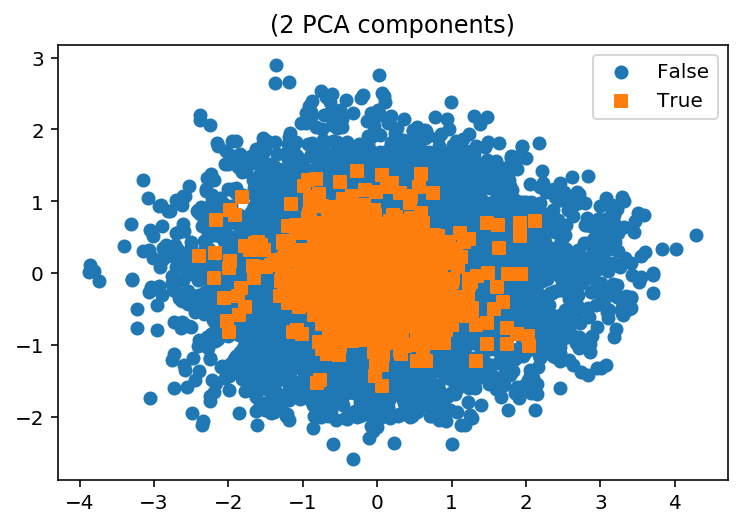

In [11]:
plot_2d_space(pca.fit_transform(testSetData), [not(x) for x in testSetLabel], '(2 PCA components)')